# DC Housing Market Analysis: Modeling

## Introduction

This notebook builds upon the exploratory data analysis performed in previous notebooks to develop predictive models for DC housing prices. We'll implement and evaluate multiple modeling approaches, from traditional time series methods to advanced machine learning techniques, to identify the most important variables and other key insights related to the DC housing market.

Our goal is to:
1. Implement various modeling approaches for housing price prediction
2. Compare model performance to identify the most effective techniques
3. Analyze key drivers of housing price changes
4. Provide actionable insights based on our findings

Let's begin by importing the necessary libraries and setting up our environment.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import pickle
from datetime import datetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Statistical and modeling libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR

# Machine learning libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

# Set visualization styling for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

# Create directory for saving outputs
output_dir = 'outputs/models_and_forecasts_final'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory set to: {output_dir}")

Output directory set to: outputs/models_and_forecasts_final


## 1. Data Loading and Preparation

First, we need to load the feature-engineered dataset created in the previous notebook. This dataset contains a wide range of economic indicators and derived features that will serve as the foundation for our models.

The dataset includes:
- Primary economic indicators (CPI, unemployment rate, interest rates, etc.)
- Housing market metrics (Zillow Home Value Index, mortgage rates)
- Demographic data (population, household income)
- Derived features (lagged variables, moving averages, growth rates)
- Interaction terms and affordability metrics

In [2]:
# Load the feature-engineered dataset
df = pd.read_csv('dc_economic_monthly_engineered_features_clean.csv')

# Convert Date column to datetime and set as index for time series analysis
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Display basic information
print(f"Dataset dimensions: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Time period: {df.index.min().strftime('%B %Y')} to {df.index.max().strftime('%B %Y')}")
print(f"Duration: {((df.index.max() - df.index.min()).days / 365.25):.1f} years")

# Display the first few rows
df.head()

Dataset dimensions: 282 rows × 142 columns
Time period: January 2001 to June 2024
Duration: 23.4 years


,Year,Month,Unemployment_Rate,CPI,Interest_Rate,Mortgage_Rate,ZHVI,GDP_Growth,Median_Household_Income,Population,Poverty_Rate,Marriage_Rate,Divorce_Rate,Unemployment_Rate_lag1,Unemployment_Rate_lag3,Unemployment_Rate_lag6,Unemployment_Rate_lag12,CPI_lag1,CPI_lag3,CPI_lag6,CPI_lag12,Interest_Rate_lag1,Interest_Rate_lag3,Interest_Rate_lag6,Interest_Rate_lag12,Mortgage_Rate_lag1,Mortgage_Rate_lag3,Mortgage_Rate_lag6,Mortgage_Rate_lag12,ZHVI_lag1,ZHVI_lag3,ZHVI_lag6,ZHVI_lag12,GDP_Growth_lag1,GDP_Growth_lag3,GDP_Growth_lag6,GDP_Growth_lag12,Median_Household_Income_lag1,Median_Household_Income_lag3,Median_Household_Income_lag6,Median_Household_Income_lag12,Population_lag1,Population_lag3,Population_lag6,Population_lag12,Poverty_Rate_lag1,Poverty_Rate_lag3,Poverty_Rate_lag6,Poverty_Rate_lag12,Marriage_Rate_lag1,Marriage_Rate_lag3,Marriage_Rate_lag6,Marriage_Rate_lag12,Divorce_Rate_lag1,Divorce_Rate_lag3,Divorce_Rate_lag6,Divorce_Rate_lag12,Unemployment_Rate_ma3,Unemployment_Rate_ma6,Unemployment_Rate_ma12,CPI_ma3,CPI_ma6,CPI_ma12,Interest_Rate_ma3,Interest_Rate_ma6,Interest_Rate_ma12,Mortgage_Rate_ma3,Mortgage_Rate_ma6,Mortgage_Rate_ma12,ZHVI_ma3,ZHVI_ma6,ZHVI_ma12,GDP_Growth_ma3,GDP_Growth_ma6,GDP_Growth_ma12,Median_Household_Income_ma3,Median_Household_Income_ma6,Median_Household_Income_ma12,Population_ma3,Population_ma6,Population_ma12,Poverty_Rate_ma3,Poverty_Rate_ma6,Poverty_Rate_ma12,Marriage_Rate_ma3,Marriage_Rate_ma6,Marriage_Rate_ma12,Divorce_Rate_ma3,Divorce_Rate_ma6,Divorce_Rate_ma12,Unemployment_Rate_mom_pct,Unemployment_Rate_yoy_pct,Unemployment_Rate_3m_pct,CPI_mom_pct,CPI_yoy_pct,CPI_3m_pct,Interest_Rate_mom_pct,Interest_Rate_yoy_pct,Interest_Rate_3m_pct,Mortgage_Rate_mom_pct,Mortgage_Rate_yoy_pct,Mortgage_Rate_3m_pct,ZHVI_mom_pct,ZHVI_yoy_pct,ZHVI_3m_pct,GDP_Growth_mom_pct,GDP_Growth_yoy_pct,GDP_Growth_3m_pct,Median_Household_Income_mom_pct,Median_Household_Income_yoy_pct,Median_Household_Income_3m_pct,Population_mom_pct,Population_yoy_pct,Population_3m_pct,Poverty_Rate_mom_pct,Poverty_Rate_yoy_pct,Poverty_Rate_3m_pct,Marriage_Rate_mom_pct,Marriage_Rate_yoy_pct,Marriage_Rate_3m_pct,Divorce_Rate_mom_pct,Divorce_Rate_yoy_pct,Divorce_Rate_3m_pct,interest_unemployment,mortgage_income,cpi_unemployment,price_to_income,monthly_payment,payment_to_income,real_mortgage_rate,month_sin,month_cos,winter,spring,summer,fall,zhvi_trend,zhvi_seasonal,zhvi_residual,zhvi_diff1,cpi_diff1,mortgage_rate_diff1
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,2001,1,5.90,175.90,5.98,7.03,193160.24,-0.44,41170.00,574.50,18.10,4.96,3.04,5.90,5.70,5.60,5.70,175.60,175.15,174.80,169.80,6.40,6.51,6.54,5.45,7.38,7.79,8.15,8.21,191629.48,188359.20,183644.45,179200.93,1.32,1.84,2.11,1.50,41523.01,42129.74,42654.93,41220.00,572.05,572.05,572.05,572.05,17.50,17.50,17.50,17.50,3.92,4.41,6.86,3.92,3.20,3.36,3.20,3.36,5.87,5.78,5.71,175.60,175.31,174.20,6.30,6.40,6.28,7.39,7.65,7.96,191568.45,189170.56,185105.05,1.09,1.04,3.14,41510.90,41928.57,42158.21,572.87,572.46,572.25,17.70,17.60,17.55,4.27,4.67,4.99,3.15,3.23,3.17,0.00,3.51,3.51,0.17,3.59,0.43,-6.56,9.72,-8.14,-4.73,-14.34,-9.78,0.80,7.79,2.55,-133.35,-129.43,-123.95,-0.85,-0.12,-2.28,0.43,0.43,0.43,3.43,3.43,3.43,26.53,26.53,12.47,-4.84,-9.38,-9.38,35.28,289528.03,1037.81,4.69,1031.45,30.06,3.44,0.50,0.87,1,0,0,0,193228.26,-801.23,733.22,1530.76,0.30,-0.35
2001-02-01,2001,2,6.00,176.55,5.49,7.05,194520.99,-1.30,40802.35,574.50,18.10,4.96,2.90,5.90,5.80,5.70,5.70,175.90,175.30,174.90,171.50,5.98,6.51,6.50,5.73,7.03,7.75,8.03,8.32,193160.24,189915.62,185187.09,179346.63,-0.44,2.40,0.40,1.50,41170.00,41839.68,42545.43,41771.03,574.50,572.05,572.05,572.05,18.10,17.50,17.50,17.50,4.96,3.92,5.88,3.92,3.04,3.20,3.20,3.20,5.93,5.83,5.73,176.02,175.58,174.62,5.96,6.23,6.26,7.15,7.49,7.86,193103.57,190726.21,186369.58,-0.14,0.75,2.91,41165.12,41638.06,42077.48,573.68,572.87,572.46,17.90,17.70,17.60,

### 1.1 Time-based Train-Test Split

For forecasting tasks, we need to be careful with how we split our data. Unlike traditional machine learning where we might use random sampling, time series forecasting requires maintaining the temporal order of observations.

We'll use a time-based split, where:
- Training data: Earlier portion of the time series (80%)
- Test data: Most recent portion of the time series (20%)

This approach simulates a real-world forecasting scenario where we use historical data to predict future values.

In [3]:
# Split the data into training and test sets (80% train, 20% test)
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

print(f"Training set: {train_df.shape[0]} observations from {train_df.index.min().strftime('%B %Y')} to {train_df.index.max().strftime('%B %Y')}")
print(f"Test set: {test_df.shape[0]} observations from {test_df.index.min().strftime('%B %Y')} to {test_df.index.max().strftime('%B %Y')}")

# Create a copy of the original ZHVI series for reference
zhvi_series = df['ZHVI'].copy()

Training set: 225 observations from January 2001 to September 2019
Test set: 57 observations from October 2019 to June 2024


### 1.2 Feature and Target Selection

Now we need to prepare our feature set for machine learning models. We'll need to be careful to avoid data leakage by excluding:

1. **Target-derived features**: Components directly derived from our target variable (ZHVI) like its lags, moving averages, or decomposition
2. **Future information**: Any features that would not be available at prediction time
3. **Non-feature columns**: Metadata columns like Year and Month (though we preserve the Date index for time series analysis)

Additionally, we'll standardize our features (mean=0, std=1) to ensure all variables are on a comparable scale, which is important for many machine learning algorithms.

In [4]:
# Define columns to exclude from features to prevent data leakage
exclude_cols = [
    'Year', 'Month', 'ZHVI',  # Target and time columns
    'zhvi_trend', 'zhvi_seasonal', 'zhvi_residual', 'zhvi_diff1',  # Decomposition components
    'ZHVI_lag1', 'ZHVI_lag3', 'ZHVI_lag6', 'ZHVI_lag12',           # Target lags
    'ZHVI_ma3', 'ZHVI_ma6', 'ZHVI_ma12',                           # Target moving averages
    'ZHVI_mom_pct', 'ZHVI_yoy_pct', 'ZHVI_3m_pct'                  # Target rate of change
]

# Select feature columns 
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Split data into features (X) and target (y)
X_train = train_df[feature_cols]
y_train = train_df['ZHVI']  # Target variable: housing prices
X_test = test_df[feature_cols]
y_test = test_df['ZHVI']

print(f"Number of selected features: {len(feature_cols)}")
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

# Standardize features for ML models
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# Save the scaler for future use
with open(f'{output_dir}/feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Display sample of the scaled features
X_train_scaled.head()

Number of selected features: 125
Training features shape: (225, 125)
Test features shape: (57, 125)


,Unemployment_Rate,CPI,Interest_Rate,Mortgage_Rate,GDP_Growth,Median_Household_Income,Population,Poverty_Rate,Marriage_Rate,Divorce_Rate,Unemployment_Rate_lag1,Unemployment_Rate_lag3,Unemployment_Rate_lag6,Unemployment_Rate_lag12,CPI_lag1,CPI_lag3,CPI_lag6,CPI_lag12,Interest_Rate_lag1,Interest_Rate_lag3,Interest_Rate_lag6,Interest_Rate_lag12,Mortgage_Rate_lag1,Mortgage_Rate_lag3,Mortgage_Rate_lag6,Mortgage_Rate_lag12,GDP_Growth_lag1,GDP_Growth_lag3,GDP_Growth_lag6,GDP_Growth_lag12,Median_Household_Income_lag1,Median_Household_Income_lag3,Median_Household_Income_lag6,Median_Household_Income_lag12,Population_lag1,Population_lag3,Population_lag6,Population_lag12,Poverty_Rate_lag1,Poverty_Rate_lag3,Poverty_Rate_lag6,Poverty_Rate_lag12,Marriage_Rate_lag1,Marriage_Rate_lag3,Marriage_Rate_lag6,Marriage_Rate_lag12,Divorce_Rate_lag1,Divorce_Rate_lag3,Divorce_Rate_lag6,Divorce_Rate_lag12,Unemployment_Rate_ma3,Unemployment_Rate_ma6,Unemployment_Rate_ma12,CPI_ma3,CPI_ma6,CPI_ma12,Interest_Rate_ma3,Interest_Rate_ma6,Interest_Rate_ma12,Mortgage_Rate_ma3,Mortgage_Rate_ma6,Mortgage_Rate_ma12,GDP_Growth_ma3,GDP_Growth_ma6,GDP_Growth_ma12,Median_Household_Income_ma3,Median_Household_Income_ma6,Median_Household_Income_ma12,Population_ma3,Population_ma6,Population_ma12,Poverty_Rate_ma3,Poverty_Rate_ma6,Poverty_Rate_ma12,Marriage_Rate_ma3,Marriage_Rate_ma6,Marriage_Rate_ma12,Divorce_Rate_ma3,Divorce_Rate_ma6,Divorce_Rate_ma12,Unemployment_Rate_mom_pct,Unemployment_Rate_yoy_pct,Unemployment_Rate_3m_pct,CPI_mom_pct,CPI_yoy_pct,CPI_3m_pct,Interest_Rate_mom_pct,Interest_Rate_yoy_pct,Interest_Rate_3m_pct,Mortgage_Rate_mom_pct,Mortgage_Rate_yoy_pct,Mortgage_Rate_3m_pct,GDP_Growth_mom_pct,GDP_Growth_yoy_pct,GDP_Growth_3m_pct,Median_Household_Income_mom_pct,Median_Household_Income_yoy_pct,Median_Household_Income_3m_pct,Population_mom_pct,Population_yoy_pct,Population_3m_pct,Poverty_Rate_mom_pct,Poverty_Rate_yoy_pct,Poverty_Rate_3m_pct,Marriage_Rate_mom_pct,Marriage_Rate_yoy_pct,Marriage_Rate_3m_pct,Divorce_Rate_mom_pct,Divorce_Rate_yoy_pct,Divorce_Rate_3m_pct,interest_unemployment,mortgage_income,cpi_unemployment,price_to_income,monthly_payment,payment_to_income,real_mortgage_rate,month_sin,month_cos,winter,spring,summer,fall,cpi_diff1,mortgage_rate_diff1
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,-1.04,-1.90,2.66,1.77,-1.14,-1.25,-0.90,0.13,-0.70,1.44,-1.04,-1.18,-1.25,-1.18,-1.89,-1.87,-1.82,-1.88,2.84,2.79,2.64,1.87,2.05,2.35,2.52,2.30,-0.34,-0.09,0.05,-0.26,-1.21,-1.16,-1.11,-1.19,-0.95,-0.93,-0.91,-0.87,-0.40,-0.43,-0.47,-0.54,-1.08,-0.88,0.04,-1.02,1.82,2.17,1.70,1.98,-1.07,-1.13,-1.21,-1.89,-1.87,-1.85,2.79,2.78,2.61,2.07,2.26,2.43,-0.47,-0.55,0.71,-1.22,-1.18,-1.15,-0.93,-0.93,-0.91,-0.23,-0.35,-0.47,-0.98,-0.88,-0.80,1.72,1.94,1.80,0.03,0.17,0.80,-0.04,1.06,-0.18,-0.49,-0.20,-0.37,-1.31,-0.97,-1.32,-0.11,-0.07,-0.08,-1.77,-0.72,-1.66,0.78,-0.71,0.20,1.75,0.55,1.03,2.04,1.13,0.25,-0.81,-0.55,-0.96,2.46,-0.04,-1.67,-1.00,-1.52,-0.14,0.62,0.70,1.24,1.74,-0.58,-0.58,-0.57,-0.15,-1.95
2001-02-01,-0.97,-1.88,2.36,1.78,-1.52,-1.27,-0.90,0.13,-0.70,1.07,-1.04,-1.12,-1.19,-1.18,-1.88,-1.86,-1.82,-1.82,2.60,2.79,2.62,2.01,1.74,2.30,2.42,2.39,-1.13,0.16,-0.73,-0.26,-1.24,-1.18,-1.12,-1.15,-0.90,-0.93,-0.91,-0.87,0.13,-0.43,-0.47,-0.54,-0.69,-1.06,-0.32,-1.02,1.42,1.77,1.70,1.60,-1.02,-1.10,-1.19,-1.87,-1.86,-1.84,2.59,2.68,2.60,1.86,2.12,2.34,-1.05,-0.70,0.56,-1.24,-1.20,-1.16,-0.91,-0.92,-0.91,-0.05,-0.26,-0.42,-0.85,-0.94,-0.76,1.46,1.81,1.73,1.08,0.29,0.78,0.60,0.54,0.22,-0.60,-0.37,-0.61,0.15,-1.05,-1.20,0.02,-0.09,-0.08,-1.84,-1.07,-1.76,-0.22,-0.71,0.20,0.02,0.55,1.03,-0.09,1.13,0.73,-0.80,-0.55,-0.96,2.23,-0.08,-1.61,-0.94,-1.49,-0.08,1.26,1.21,0.72,1.74,-0.58,-0.58,-0.57,0.36,0.20
2001-03-01,-0.90,-1.85,2.25,1.69,-1.11,-1.29,-0.90,0.13,-0.47,1.07,-0.97,-1.05,-1.19,-1.18,-1.85,-1.85,-1.81,-1.76,2.31,2.72,2.63,2.08,1.76,1.98,2.32,2.32,-1.52,-0.33,-0.60,2.

### 1.3 Model Evaluation Function

Before building models, let's define a comprehensive evaluation function that will:
1. Calculate key regression metrics (RMSE, MAE, R², MAPE)
2. Visualize actual vs. predicted values 
3. Analyze residuals to check for patterns or issues
4. Save high-quality visualizations and metrics

This will ensure consistent evaluation across all models and provide detailed insights into model performance.

In [5]:
def evaluate_model(y_true, y_pred, model_name='Model', plot=True):
    """Comprehensive model evaluation function
    
    Parameters:
    -----------
    y_true : array-like
        Actual target values
    y_pred : array-like
        Predicted target values
    model_name : str
        Name of the model for reporting
    plot : bool
        Whether to create visualization plots
        
    Returns:
    --------
    dict
        Dictionary with performance metrics
    """
    # Ensure inputs are properly aligned
    if isinstance(y_true, pd.Series) and isinstance(y_pred, pd.Series):
        y_true, y_pred = y_true.align(y_pred, join='inner')
    elif not isinstance(y_pred, pd.Series) and isinstance(y_true, pd.Series):
        y_pred = pd.Series(y_pred, index=y_true.index)
    
    # Calculate error metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate MAPE (avoiding division by zero)
    mask = y_true != 0
    mape = mean_absolute_percentage_error(y_true[mask], y_pred[mask]) * 100 if sum(mask) > 0 else np.nan
    
    # Calculate directional accuracy (how often the model correctly predicts the direction of change)
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    direction_match = np.sign(y_true_diff) == np.sign(y_pred_diff)
    directional_accuracy = np.mean(direction_match) * 100  # Convert to percentage
    
    # Print evaluation metrics
    print(f"\n===== {model_name} Performance =====")
    print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
    print(f"Mean Absolute Error (MAE): ${mae:.2f}")
    if not np.isnan(mape):
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")
    
    # Create visualizations
    if plot:
        # Plot actual vs predicted values
        plt.figure(figsize=(14, 8))
        plt.plot(y_true.index, y_true, label='Actual', linewidth=2.5, color='#1f77b4')
        plt.plot(y_pred.index, y_pred, label='Predicted', linewidth=2.5, color='#d62728')
        plt.title(f'{model_name}: Housing Price Predictions', fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('Housing Price (ZHVI, $)')
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        
        # Add shading for test period
        min_test_date = y_test.index.min()
        plt.axvspan(min_test_date, y_test.index.max(), alpha=0.1, color='gray')
        plt.axvline(x=min_test_date, color='gray', linestyle='--', alpha=0.8)
        plt.text(min_test_date, y_true.max()*0.9, 'Test Set', 
                 fontsize=12, ha='right', rotation=90, va='top')
        
        # Format y-axis with dollar signs
        plt.gca().yaxis.set_major_formatter('${x:,.0f}')
        
        # Add annotations with key metrics
        plt.annotate(f'RMSE: ${rmse:,.0f}', xy=(0.02, 0.95), xycoords='axes fraction', 
                     fontsize=12, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))
        plt.annotate(f'R²: {r2:.4f}', xy=(0.02, 0.89), xycoords='axes fraction', 
                     fontsize=12, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/{model_name.replace(" ", "_").lower()}_predictions.png')
        plt.show()
        
        # Plot residuals
        residuals = y_true - y_pred
        
        plt.figure(figsize=(14, 10))
        
        # Residual time series
        plt.subplot(2, 1, 1)
        plt.plot(residuals.index, residuals, color='#2ca02c', linewidth=2)
        plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
        plt.title(f'{model_name}: Residuals Over Time', fontweight='bold')
        plt.ylabel('Residual ($)')
        plt.grid(True, alpha=0.3)
        
        # Add shading for test period
        plt.axvspan(min_test_date, y_test.index.max(), alpha=0.1, color='gray')
        
        # Residual histogram
        plt.subplot(2, 1, 2)
        sns.histplot(residuals, kde=True, color='#2ca02c', alpha=0.7, bins=30)
        plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
        plt.title('Residual Distribution', fontweight='bold')
        plt.xlabel('Residual ($)')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/{model_name.replace(" ", "_").lower()}_residuals.png')
        plt.show()
    
    # Return metrics as a dictionary
    return {
        'model_name': model_name,
        'rmse': float(rmse),
        'mae': float(mae),
        'mape': float(mape) if not np.isnan(mape) else None,
        'r2': float(r2),
        'directional_accuracy': float(directional_accuracy)
    }

## 2. Time Series Models

We'll start with traditional time series models, which are specifically designed to capture temporal patterns in data. These models focus on using past values and patterns to predict future values.

### 2.1 ARIMA Model

ARIMA (AutoRegressive Integrated Moving Average) is a classical time series model that combines:
- **AR**: AutoRegressive component - uses past values to predict future values
- **I**: Integrated component - differencing to make the series stationary 
- **MA**: Moving Average component - uses past forecast errors

Based on our EDA, we'll try an ARIMA(1,1,1) model, which means:
- p=1: One lag of the stationarized series in the forecasting equation
- d=1: First-differencing to achieve stationarity
- q=1: One lag of the forecast error in the prediction equation

In [20]:
# Define a function to fit and evaluate ARIMA-type models
def fit_arima_model(train_data, test_data, order, seasonal_order=None, exog_train=None, exog_test=None):
    """Fit an ARIMA or SARIMA model and evaluate performance"""
    try:
        # Determine model type
        if seasonal_order:
            # SARIMA model (includes seasonal component)
            model = SARIMAX(
                train_data,
                exog=exog_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            model_name = f"SARIMA{order}{seasonal_order}"
        else:
            # ARIMA model (non-seasonal)
            model = ARIMA(train_data, exog=exog_train, order=order)
            model_name = f"ARIMA{order}"
        
        # Add exogenous variables to model name if used
        if exog_train is not None:
            if isinstance(exog_train, pd.DataFrame):
                model_name += f" with {len(exog_train.columns)} exogenous variables"
            else:
                model_name += " with exogenous variables"
        
        print(f"\nFitting {model_name}...")
        
        # Fit the model
        fitted_model = model.fit() # Suppress convergence messages
        
        # Generate predictions
        if exog_test is not None:
            # If using exogenous variables, include them in forecast
            test_pred = fitted_model.forecast(steps=len(test_data), exog=exog_test)
        else:
            # Simple forecast without exogenous variables
            test_pred = fitted_model.forecast(steps=len(test_data))
        
        # Convert predictions to Series with the same index as test data
        if isinstance(test_data, pd.Series):
            test_pred = pd.Series(test_pred, index=test_data.index)
        
        # Evaluate model performance
        metrics = evaluate_model(test_data, test_pred, model_name=model_name)
        
        # Save the model
        with open(f'{output_dir}/{model_name.replace(" ", "_").lower()}.pkl', 'wb') as f:
            pickle.dump(fitted_model, f)
        
        return fitted_model, test_pred, metrics
    
    except Exception as e:
        print(f"Error fitting {model_name if 'model_name' in locals() else 'ARIMA model'}: {e}")
        return None, None, None


Fitting ARIMA(1, 1, 1)...

===== ARIMA(1, 1, 1) Performance =====
Root Mean Squared Error (RMSE): $81994.44
Mean Absolute Error (MAE): $71682.70
Mean Absolute Percentage Error (MAPE): 13.67%
R-squared (R²): -2.7549
Directional Accuracy: 82.14%


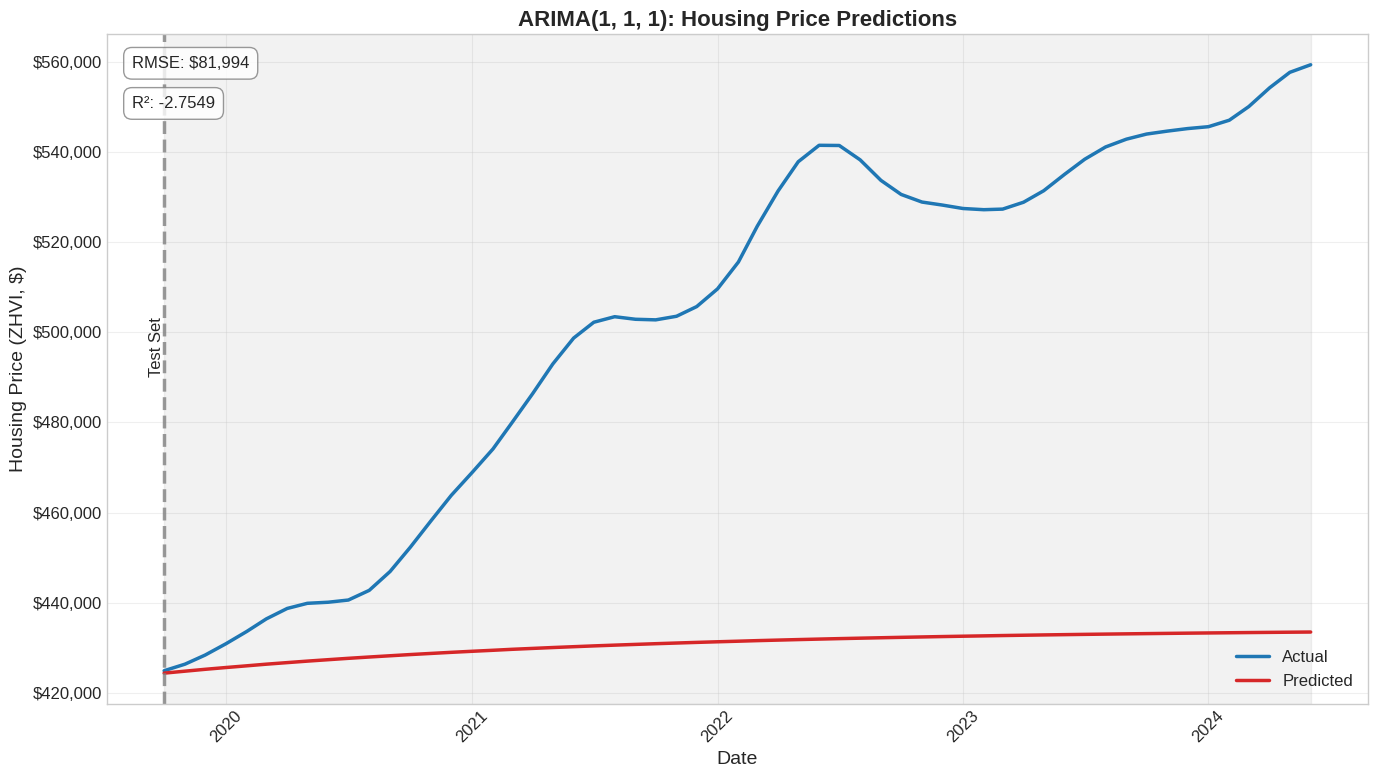

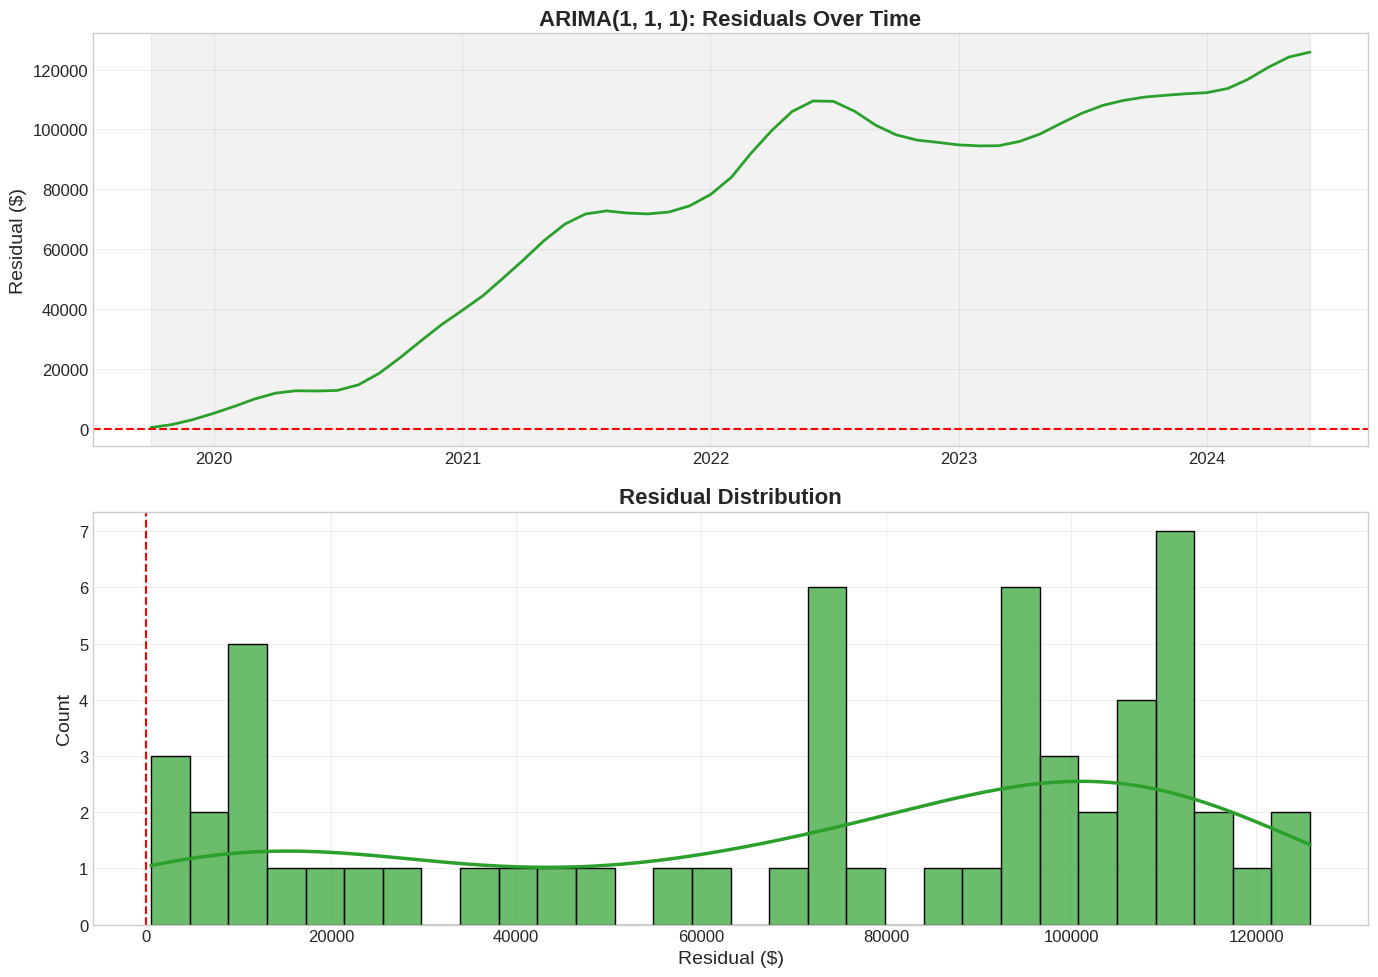


ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                   ZHVI   No. Observations:                  225
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2037.401
Date:                Sat, 08 Mar 2025   AIC                           4080.802
Time:                        19:44:37   BIC                           4091.037
Sample:                    01-01-2001   HQIC                          4084.933
                         - 09-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9564      0.008    114.280      0.000       0.940       0.973
ma.L1         -0.9229      0.011    -87.858      0.000      -0.943      -0.902
sigma2      4.379e+06   5.35e-

In [21]:
# Fit ARIMA(1,1,1) model to the ZHVI series
arima_model, arima_pred, arima_metrics = fit_arima_model(
    train_df['ZHVI'],  # Training data (target variable only) 
    test_df['ZHVI'],   # Test data (for evaluation)
    order=(1, 1, 1)    # (p, d, q) parameters
)

# Display model summary
if arima_model:
    print("\nARIMA Model Summary:")
    print(arima_model.summary())

### 2.2 SARIMA Model

SARIMA (Seasonal ARIMA) extends the ARIMA model to capture seasonal patterns. It adds seasonal components:
- **P**: Seasonal autoregressive order
- **D**: Seasonal differencing order
- **Q**: Seasonal moving average order
- **S**: Seasonal period (12 for monthly data)

Our EDA revealed seasonal patterns in housing prices with peaks in summer months, so we'll implement a SARIMA model to capture this seasonality.


Fitting SARIMA(1, 1, 1)(1, 0, 1, 12)...

===== SARIMA(1, 1, 1)(1, 0, 1, 12) Performance =====
Root Mean Squared Error (RMSE): $78176.05
Mean Absolute Error (MAE): $68347.85
Mean Absolute Percentage Error (MAPE): 13.03%
R-squared (R²): -2.4134
Directional Accuracy: 82.14%


/home/vboxuser/25-spring-rding/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


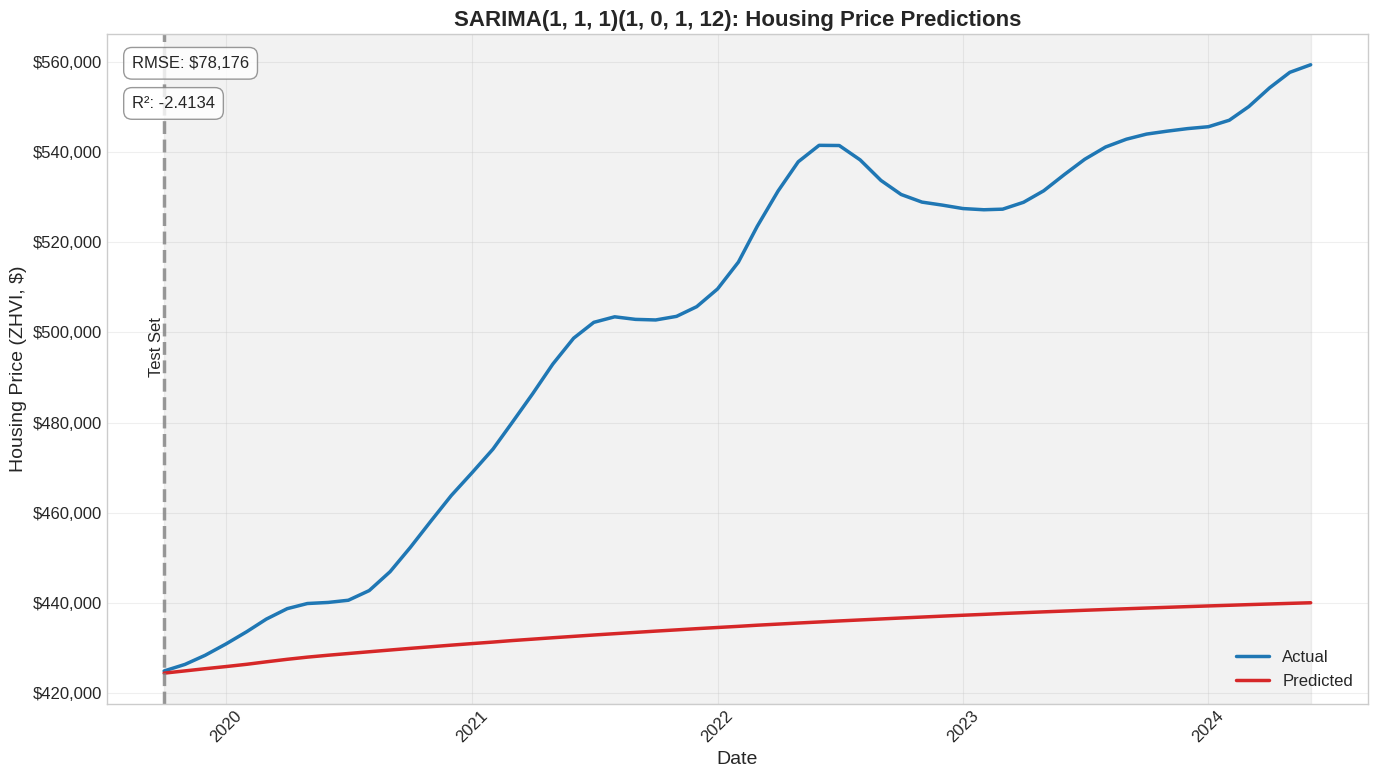

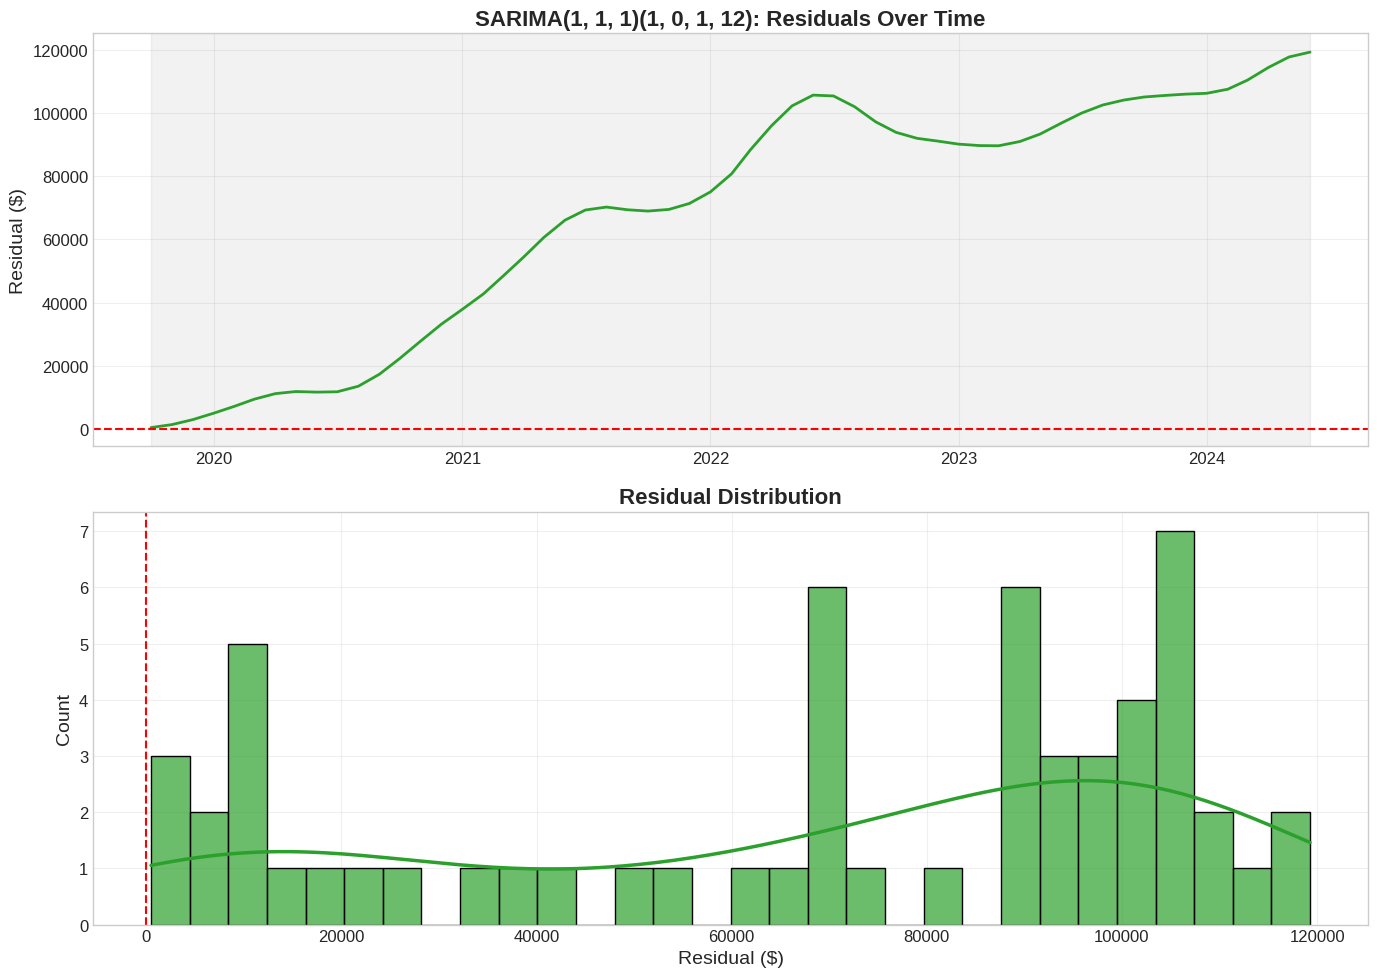


SARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                               ZHVI   No. Observations:                  225
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1550.598
Date:                            Sat, 08 Mar 2025   AIC                           3111.195
Time:                                    19:44:46   BIC                           3127.931
Sample:                                01-01-2001   HQIC                          3117.961
                                     - 09-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9773      0.014     71.878      0.000       0.951       1.004
ma.L1       

In [22]:
# Fit SARIMA model with seasonal component (period=12 for monthly data)
sarima_model, sarima_pred, sarima_metrics = fit_arima_model(
    train_df['ZHVI'],  # Training data (target variable only)
    test_df['ZHVI'],   # Test data (for evaluation)
    order=(1, 1, 1),   # (p, d, q) parameters
    seasonal_order=(1, 0, 1, 12)  # (P, D, Q, S) seasonal parameters
)

# Display model summary
if sarima_model:
    print("\nSARIMA Model Summary:")
    print(sarima_model.summary())

### 2.3 ARIMAX Model (ARIMA with Exogenous Variables)

ARIMAX extends ARIMA by incorporating external (exogenous) variables that may influence the target variable. This allows us to incorporate economic indicators like interest rates, unemployment, and income levels into our forecast.

Based on our correlation analysis, we'll select key economic indicators that showed strong relationships with housing prices.


Fitting ARIMA(1, 1, 1) with 4 exogenous variables...

===== ARIMA(1, 1, 1) with 4 exogenous variables Performance =====
Root Mean Squared Error (RMSE): $32999.92
Mean Absolute Error (MAE): $29386.43
Mean Absolute Percentage Error (MAPE): 5.83%
R-squared (R²): 0.3918
Directional Accuracy: 66.07%


/home/vboxuser/25-spring-rding/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


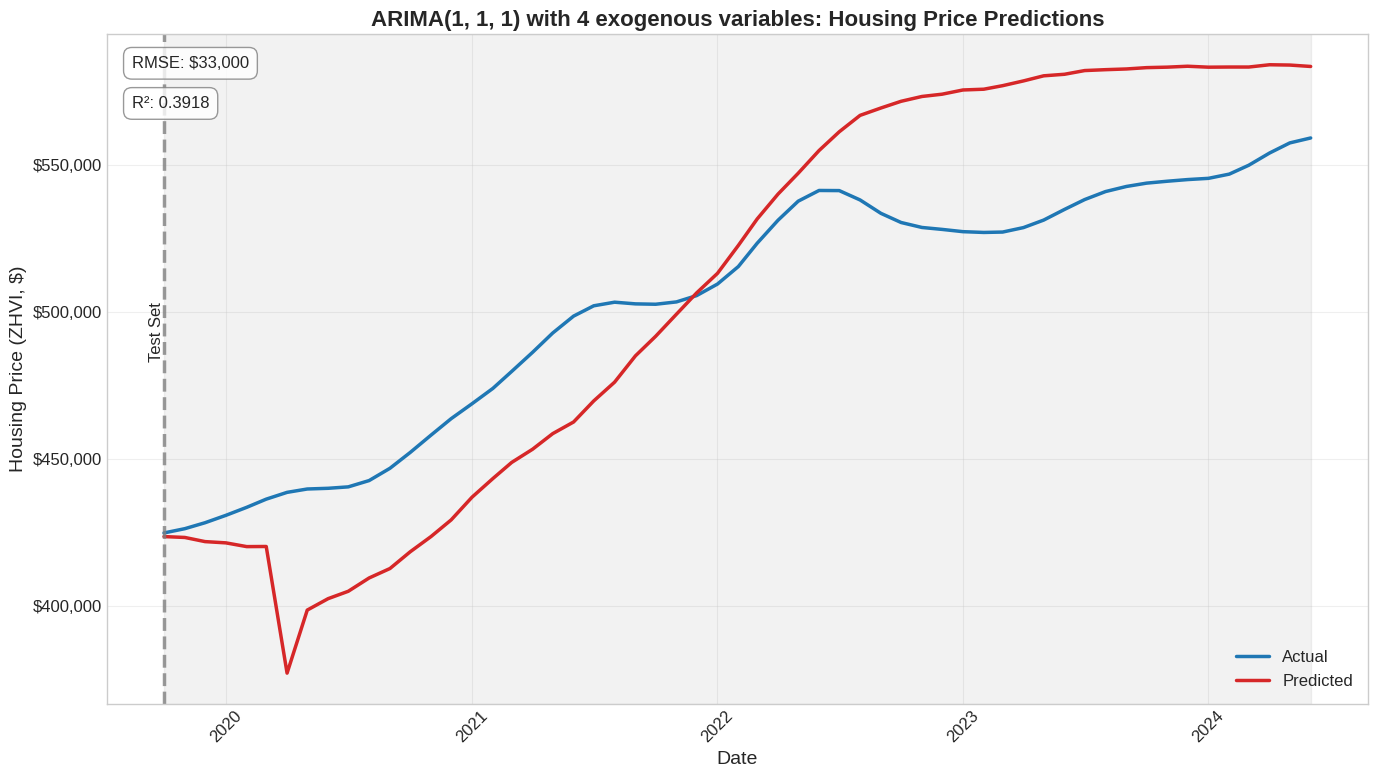

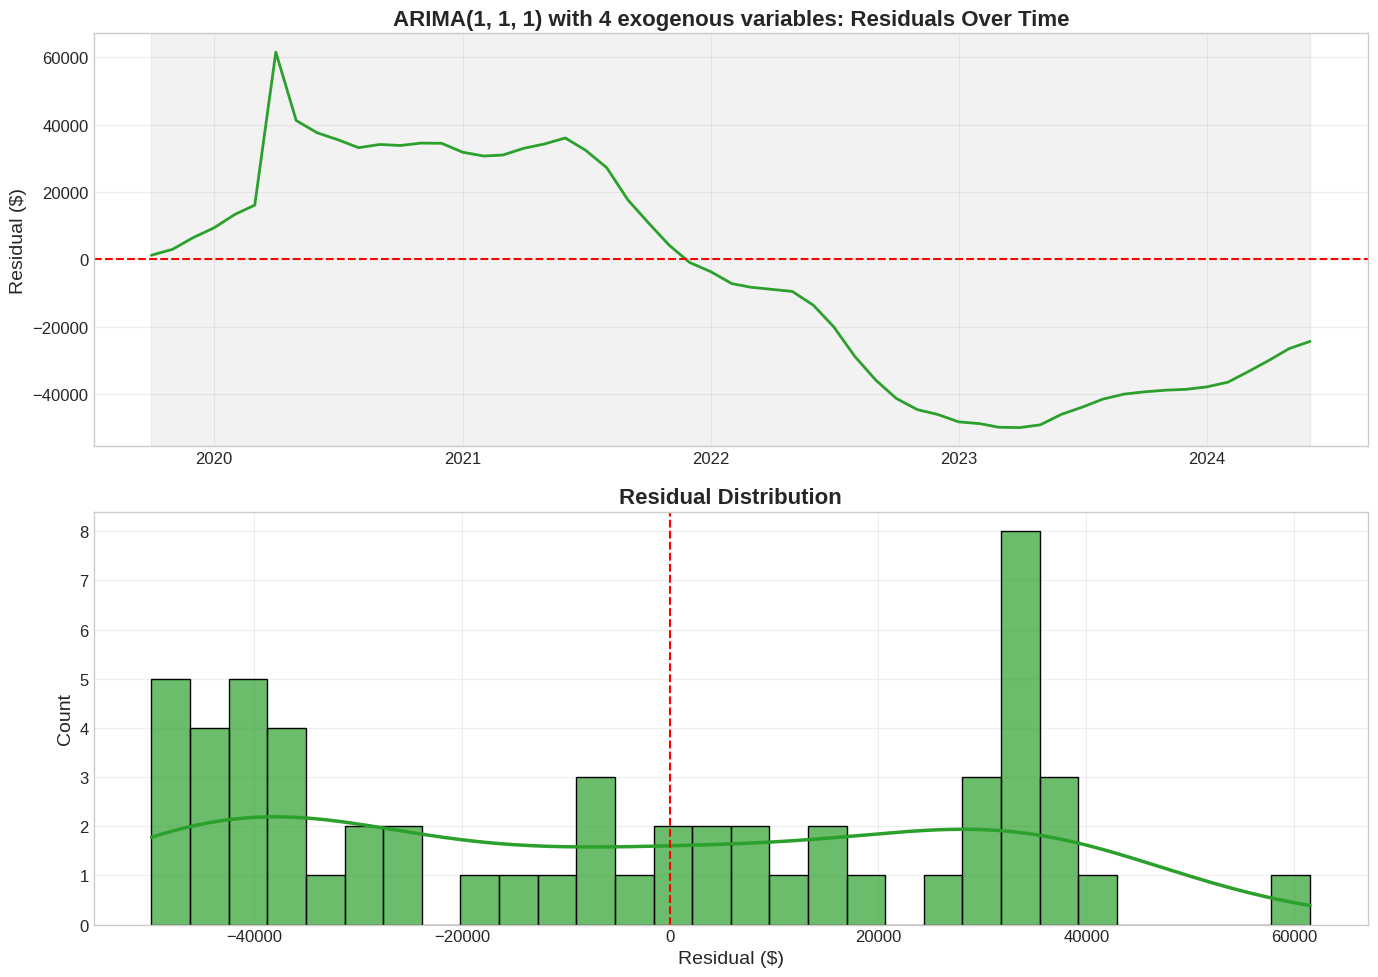


ARIMAX Model Summary:
                               SARIMAX Results                                
Dep. Variable:                   ZHVI   No. Observations:                  225
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1833.725
Date:                Sat, 08 Mar 2025   AIC                           3681.450
Time:                        19:44:53   BIC                           3705.331
Sample:                    01-01-2001   HQIC                          3691.090
                         - 09-01-2019                                         
Covariance Type:                  opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Mortgage_Rate             454.2493    324.232      1.401      0.161    -181.234    1089.733
CPI                       302.7992     69.836      4.336      0.000  

In [23]:
# Select key economic indicators as exogenous variables
exog_vars = ['Mortgage_Rate', 'CPI', 'Unemployment_Rate', 'Median_Household_Income']

# Fit ARIMAX model with exogenous variables
arimax_model, arimax_pred, arimax_metrics = fit_arima_model(
    train_df['ZHVI'],          # Training data (target variable)
    test_df['ZHVI'],           # Test data (for evaluation)
    order=(1, 1, 1),           # (p, d, q) parameters
    exog_train=train_df[exog_vars],  # Exogenous variables for training
    exog_test=test_df[exog_vars]     # Exogenous variables for testing
)

# Display model summary
if arimax_model:
    print("\nARIMAX Model Summary:")
    print(arimax_model.summary())

## 3. Machine Learning Models

Now, let's implement machine learning models that can capture complex, potentially non-linear relationships between our features and target variable. Unlike time series models that focus primarily on temporal patterns, these models can leverage the full range of economic indicators and derived features.

We'll start with simpler models and progressively move to more complex ones.

### 3.1 Linear Regression Models

Linear regression models are interpretable and provide a good baseline for more complex approaches. They model the target variable as a linear combination of features.


Fitting Linear Regression...

===== Linear Regression Performance =====
Root Mean Squared Error (RMSE): $9773.38
Mean Absolute Error (MAE): $8104.68
Mean Absolute Percentage Error (MAPE): 1.62%
R-squared (R²): 0.9467
Directional Accuracy: 85.71%


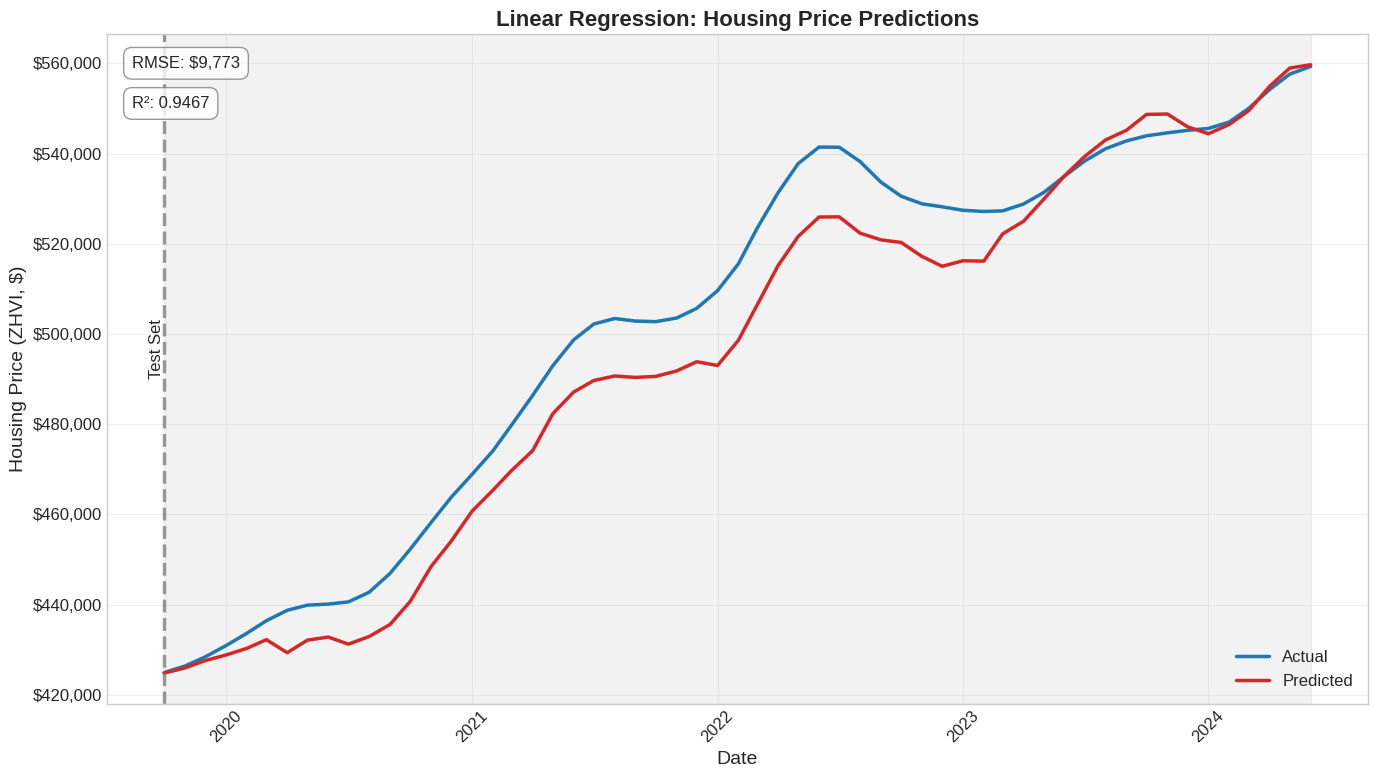

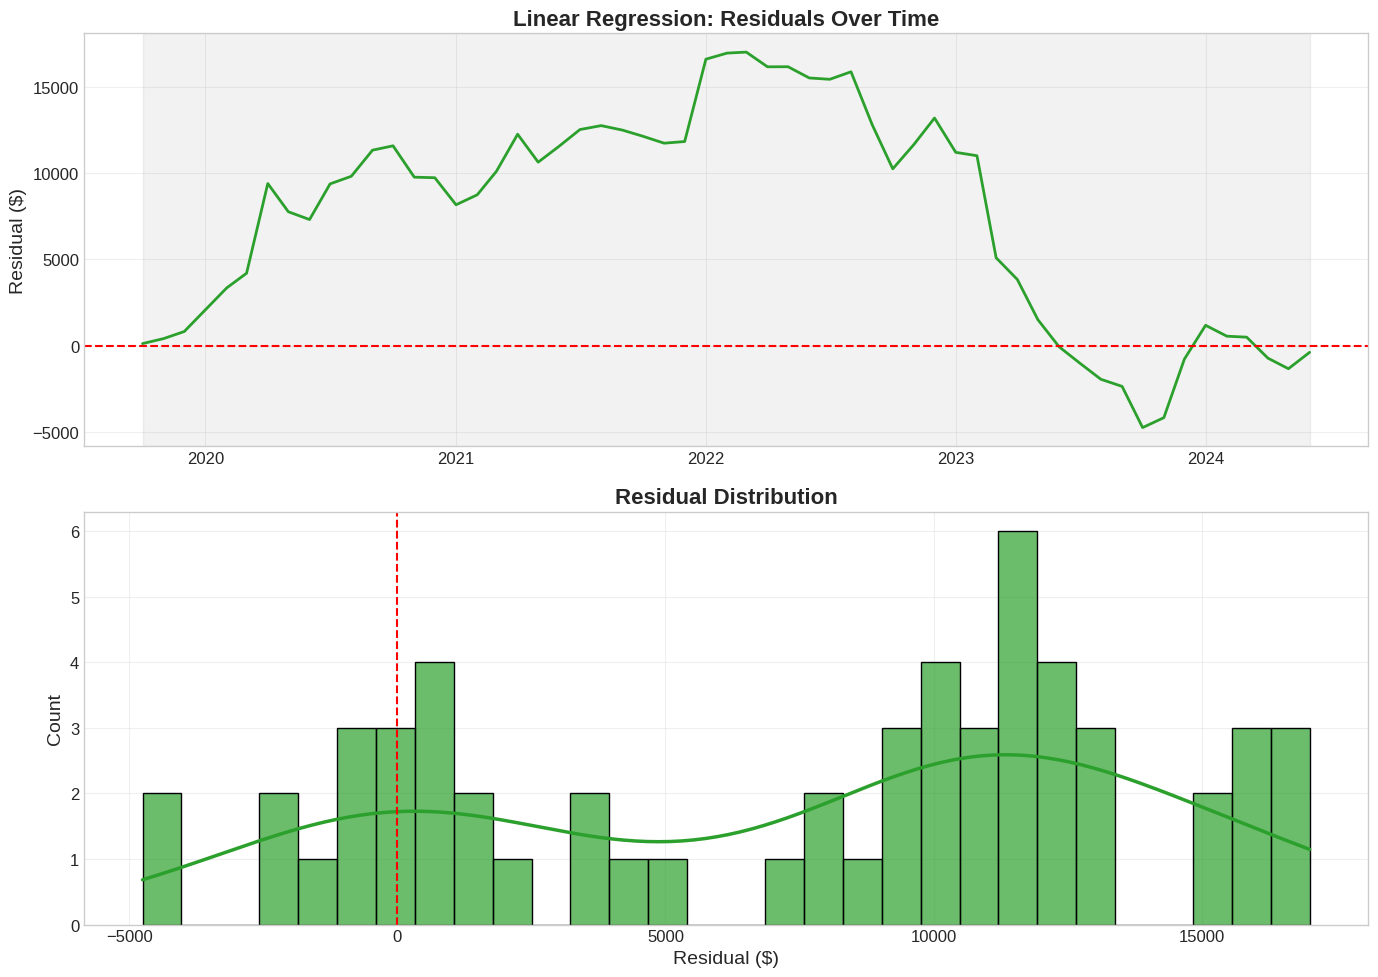

In [24]:
# Linear Regression
print("\nFitting Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_metrics = evaluate_model(y_test, lr_pred, model_name='Linear Regression')

# Save the model
with open(f'{output_dir}/linear_regression_model.pkl', 'wb') as f:
    pickle.dump(lr, f)

#### Feature Importance Analysis for Linear Regression

One advantage of linear models is their interpretability. The coefficients directly indicate the impact of each feature on the prediction, allowing us to identify the most influential factors in housing price determination.

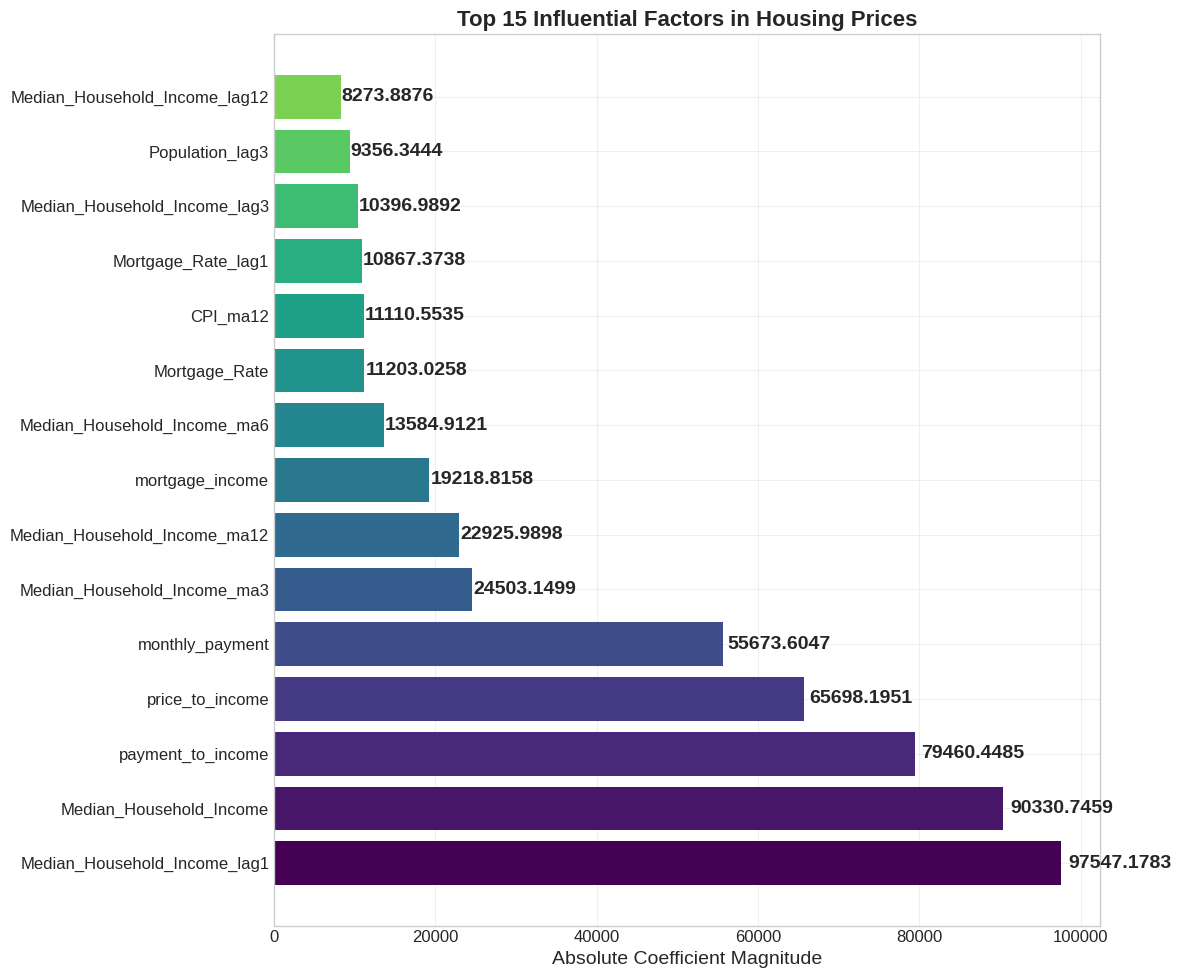

In [25]:
# Create feature importance DataFrame for Linear Regression
lr_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr.coef_
})
lr_importance['Abs_Coefficient'] = np.abs(lr_importance['Coefficient'])
lr_importance = lr_importance.sort_values('Abs_Coefficient', ascending=False).head(15)

# Create a horizontal bar chart of feature importance
plt.figure(figsize=(12, 10))
colors = plt.cm.viridis(np.linspace(0, 0.8, len(lr_importance)))
bars = plt.barh(lr_importance['Feature'], lr_importance['Abs_Coefficient'], color=colors)
plt.title('Top 15 Influential Factors in Housing Prices', fontweight='bold')
plt.xlabel('Absolute Coefficient Magnitude')
plt.grid(True, axis='x', alpha=0.3)

# Add value labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2, f'{width:.4f}', 
             ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}/feature_importance_linear.png')
plt.show()

### 3.2 Regularized Linear Models

Regularized linear models add penalties to the coefficient sizes to prevent overfitting and perform automatic feature selection. We'll try:

- **Ridge Regression**: Uses L2 regularization (penalizes squared coefficient magnitude)
- **Lasso Regression**: Uses L1 regularization (encourages sparse solutions with some coefficients becoming exactly zero)

These models can be more robust than standard linear regression, especially with many features or correlated features.


Fitting Ridge Regression...

===== Ridge Regression Performance =====
Root Mean Squared Error (RMSE): $42435.68
Mean Absolute Error (MAE): $37545.51
Mean Absolute Percentage Error (MAPE): 7.56%
R-squared (R²): -0.0058
Directional Accuracy: 62.50%


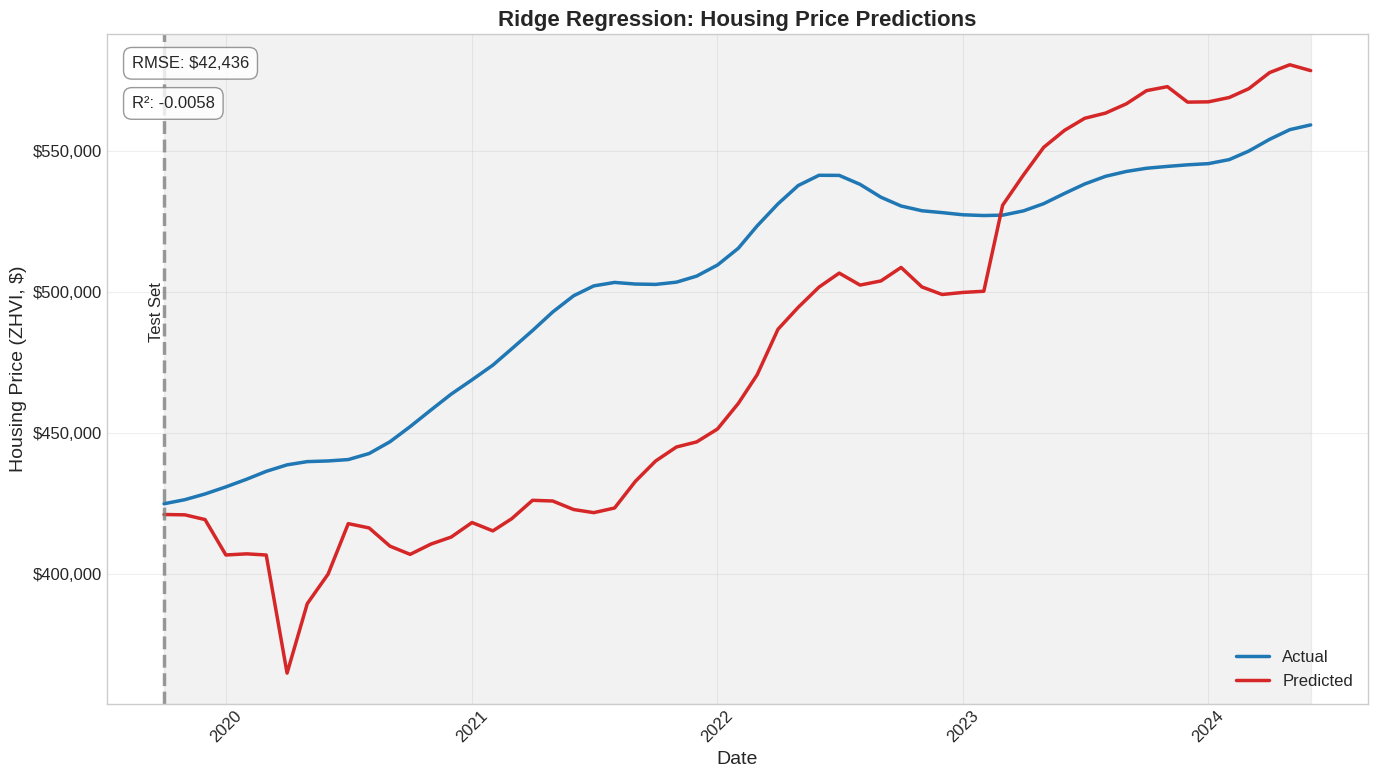

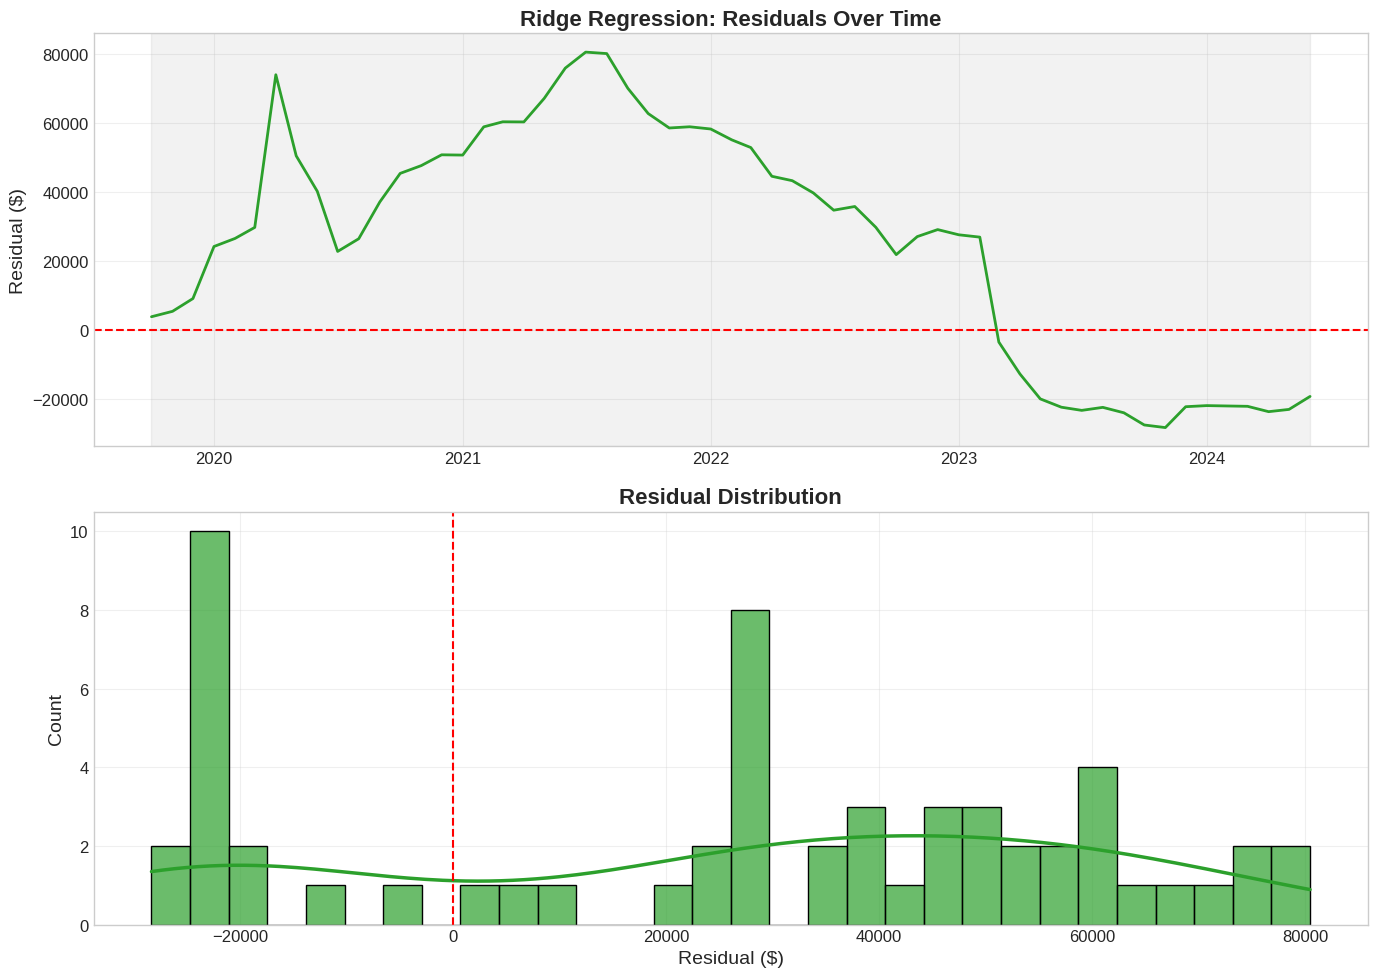

In [26]:
# Ridge Regression (L2 regularization)
print("\nFitting Ridge Regression...")
ridge = Ridge(alpha=1.0)  # alpha controls regularization strength
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)
ridge_metrics = evaluate_model(y_test, ridge_pred, model_name='Ridge Regression')

# Save the model
with open(f'{output_dir}/ridge_regression_model.pkl', 'wb') as f:
    pickle.dump(ridge, f)


Fitting Lasso Regression...

===== Lasso Regression Performance =====
Root Mean Squared Error (RMSE): $25878.67
Mean Absolute Error (MAE): $21286.85
Mean Absolute Percentage Error (MAPE): 4.31%
R-squared (R²): 0.6260
Directional Accuracy: 58.93%


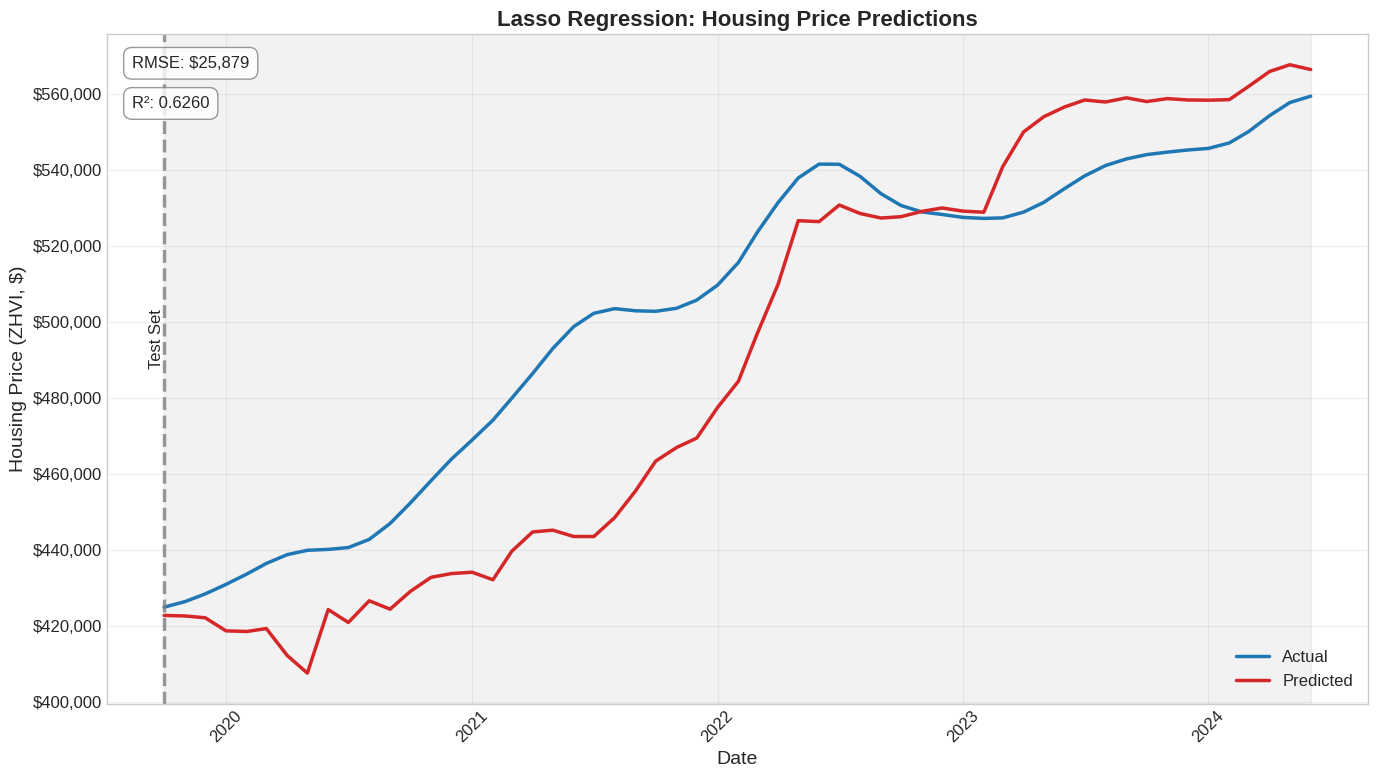

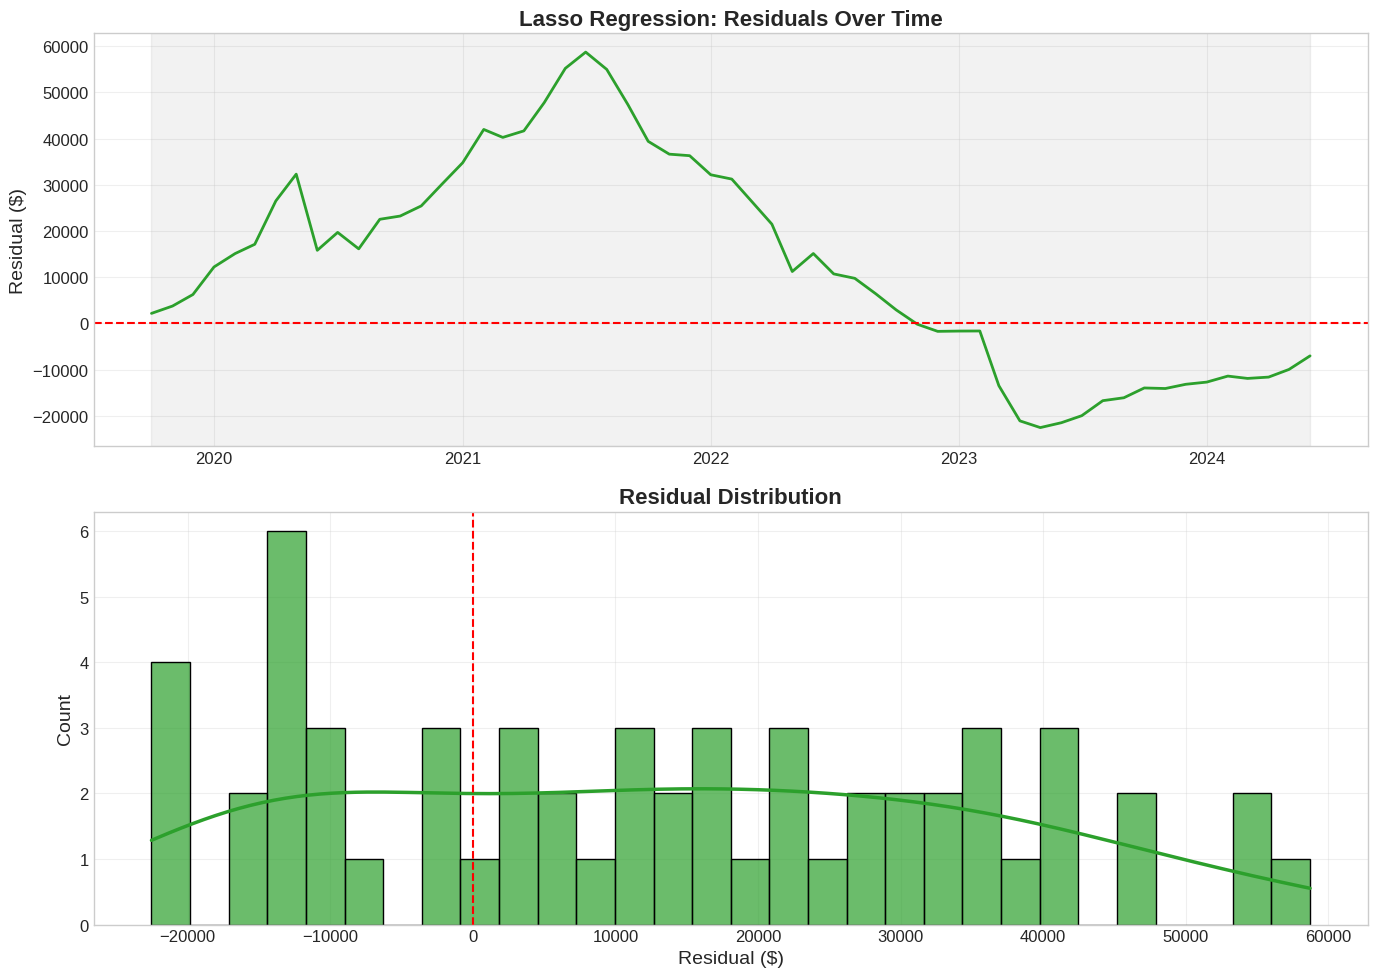


Lasso selected 124 out of 125 features

Top 10 features selected by Lasso:


,Feature,Coefficient
1,CPI,47341.29
113,price_to_income,44322.14
114,monthly_payment,20340.68
115,payment_to_income,-17831.21
53,CPI_ma3,-10148.49
5,Median_Household_Income,9512.41
0,Unemployment_Rate,-9481.03
30,Median_Household_Income_lag1,9422.27
14,CPI_lag1,-8568.89
111,mortgage_income,-8098.35


In [27]:
# Lasso Regression (L1 regularization)
print("\nFitting Lasso Regression...")
lasso = Lasso(alpha=0.1)  # alpha controls regularization strength
lasso.fit(X_train_scaled, y_train)
lasso_pred = lasso.predict(X_test_scaled)
lasso_metrics = evaluate_model(y_test, lasso_pred, model_name='Lasso Regression')

# Save the model
with open(f'{output_dir}/lasso_regression_model.pkl', 'wb') as f:
    pickle.dump(lasso, f)

# Analyze which features were selected (non-zero coefficients)
lasso_coefs = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lasso.coef_
})
selected_features = lasso_coefs[lasso_coefs['Coefficient'] != 0].sort_values(by='Coefficient', key=abs, ascending=False)

print(f"\nLasso selected {len(selected_features)} out of {len(feature_cols)} features")
print("\nTop 10 features selected by Lasso:")
display(selected_features.head(10))

### 3.3 Tree-Based Models

Tree-based models can capture non-linear relationships and feature interactions that linear models might miss. We'll implement:

- **Random Forest**: Ensemble of decision trees where each tree is built on a random subset of data and features
- **Gradient Boosting**: Sequential ensemble where each new tree corrects errors made by previous trees

These models are powerful but may be more prone to overfitting without proper tuning.


Fitting Random Forest...

===== Random Forest Performance =====
Root Mean Squared Error (RMSE): $120269.78
Mean Absolute Error (MAE): $113652.60
Mean Absolute Percentage Error (MAPE): 22.18%
R-squared (R²): -7.0788
Directional Accuracy: 48.21%


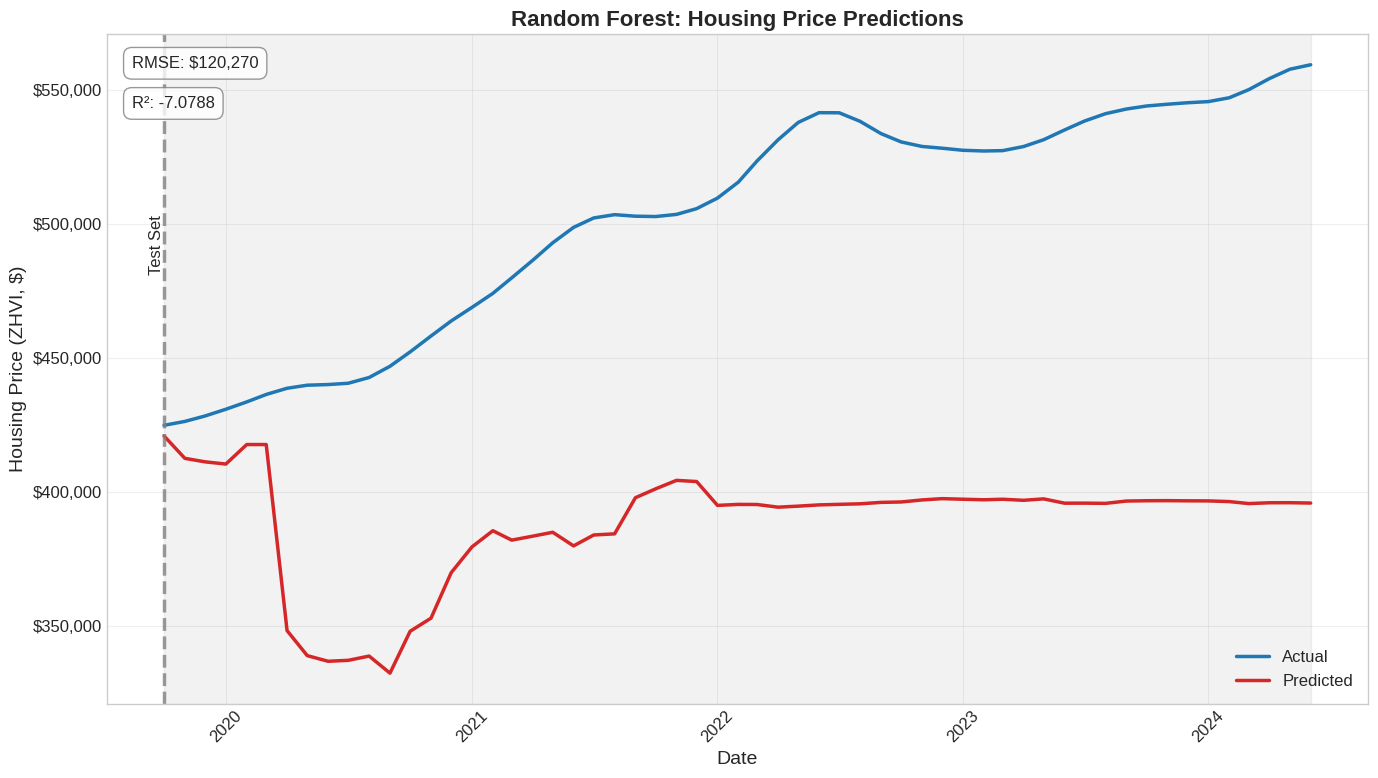

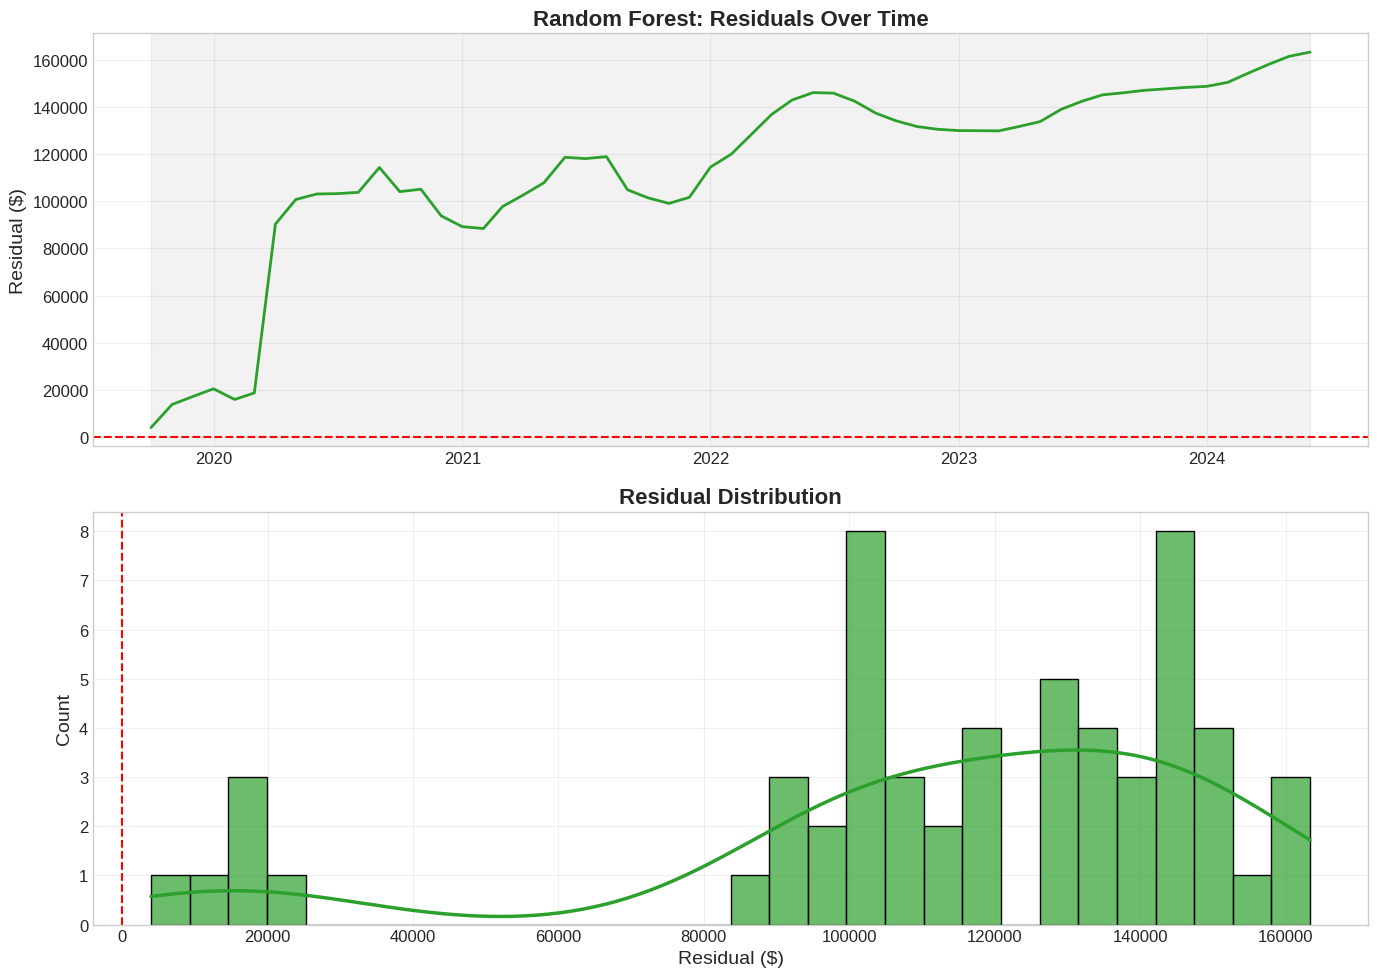

In [28]:
# Random Forest Regressor
print("\nFitting Random Forest...")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # Note: tree-based models can handle unscaled data
rf_pred = rf.predict(X_test)
rf_metrics = evaluate_model(y_test, rf_pred, model_name='Random Forest')

# Save the model
with open(f'{output_dir}/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

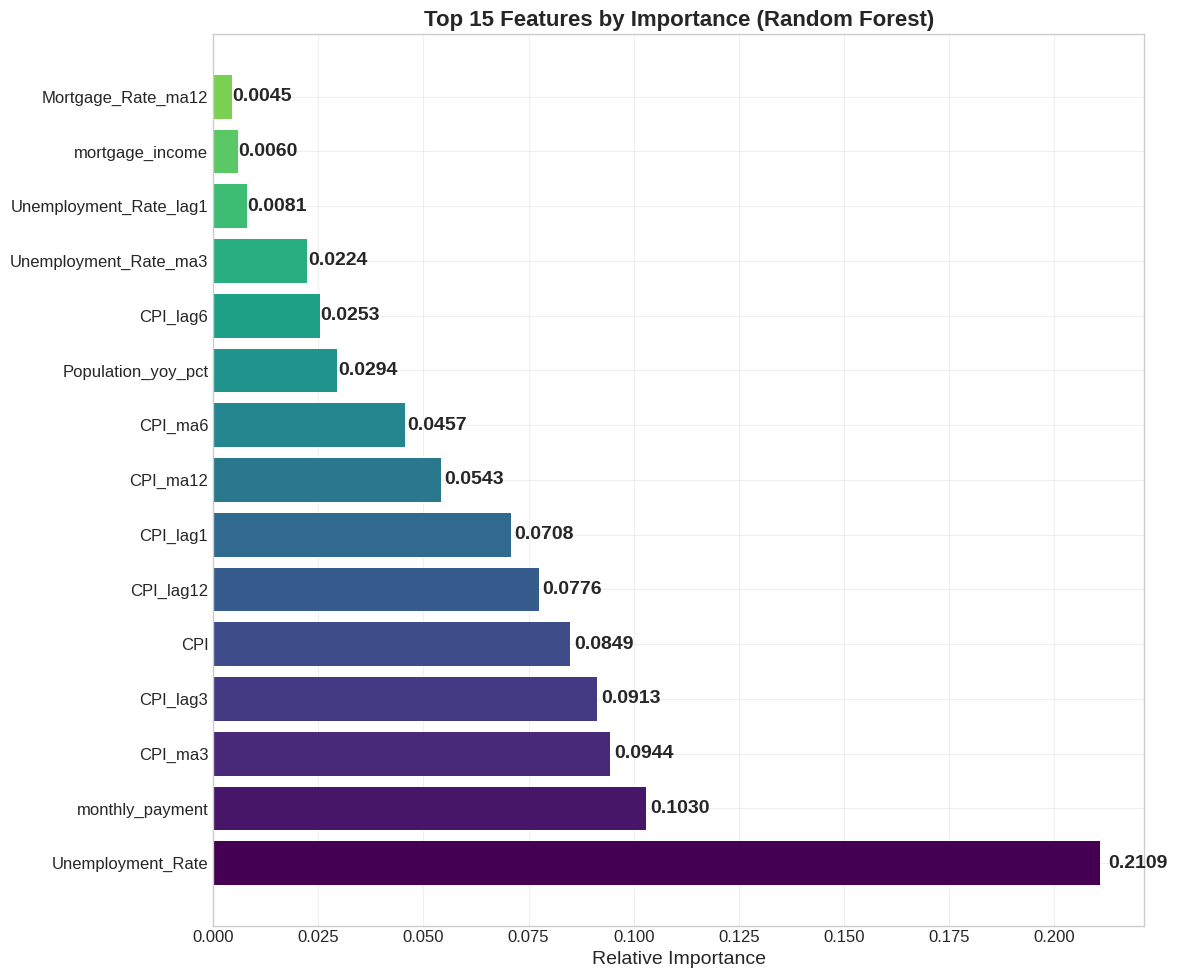

In [29]:
# Create feature importance visualization for Random Forest
rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(12, 10))
colors = plt.cm.viridis(np.linspace(0, 0.8, len(rf_importance)))
bars = plt.barh(rf_importance['Feature'], rf_importance['Importance'], color=colors)
plt.title('Top 15 Features by Importance (Random Forest)', fontweight='bold')
plt.xlabel('Relative Importance')
plt.grid(True, axis='x', alpha=0.3)

# Add value labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2, f'{width:.4f}', 
             ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}/feature_importance_random_forest.png')
plt.show()


Fitting Gradient Boosting...

===== Gradient Boosting Performance =====
Root Mean Squared Error (RMSE): $119906.22
Mean Absolute Error (MAE): $113492.27
Mean Absolute Percentage Error (MAPE): 22.15%
R-squared (R²): -7.0300
Directional Accuracy: 53.57%


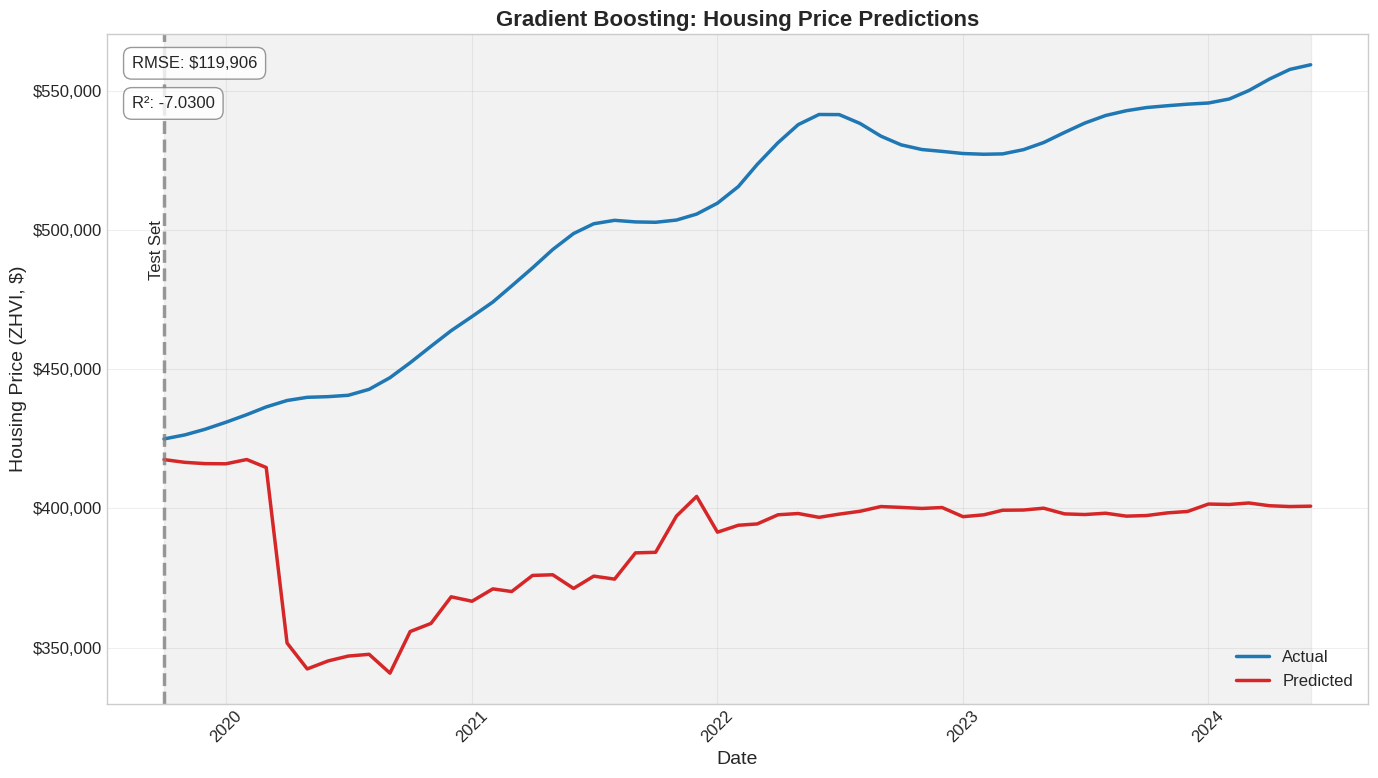

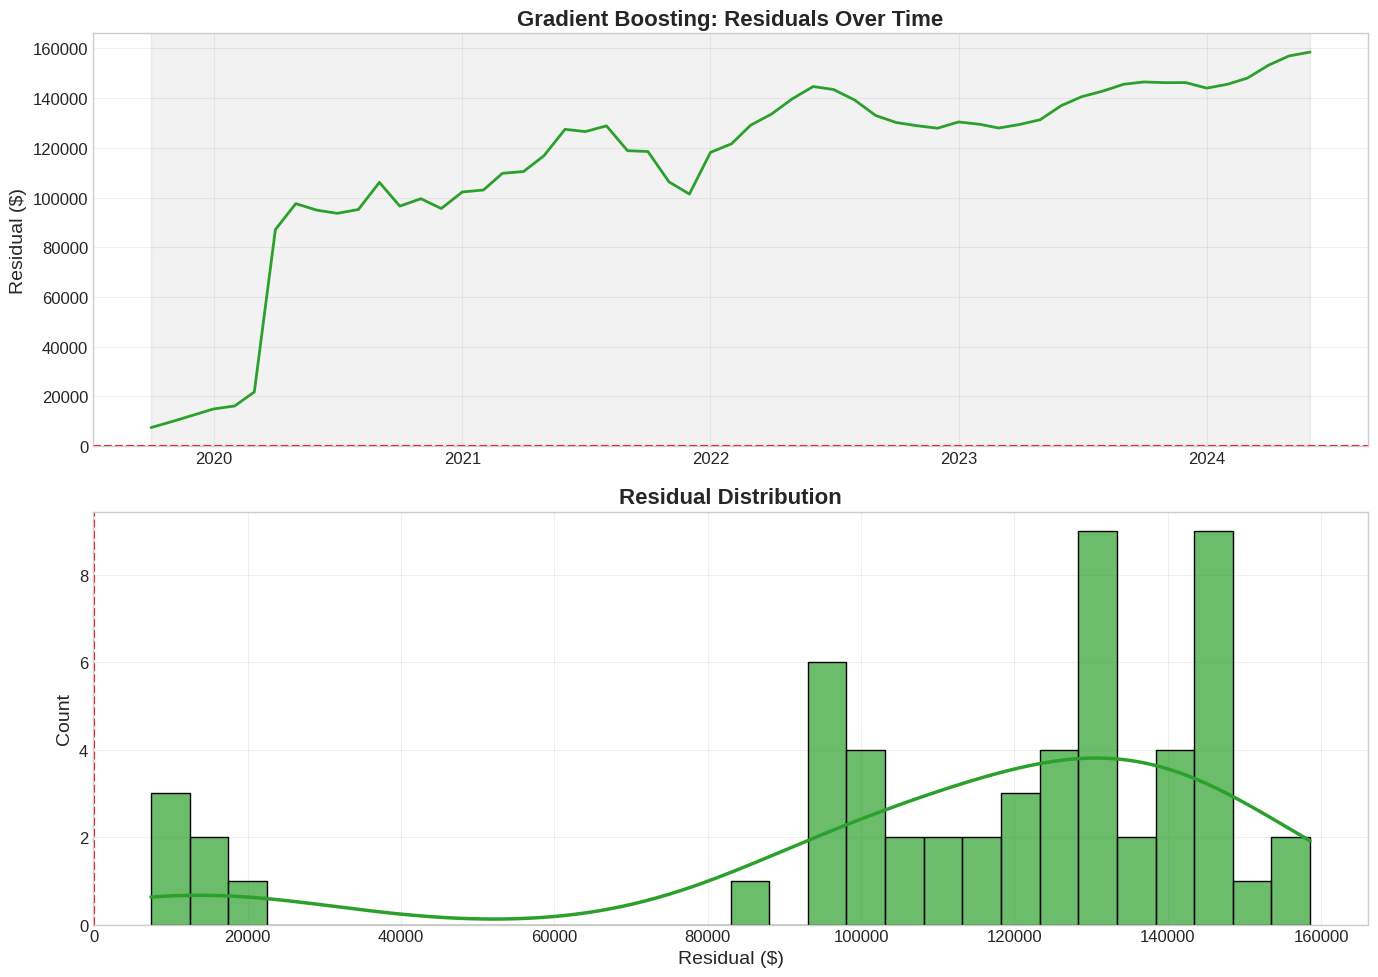

In [30]:
# Gradient Boosting Regressor
print("\nFitting Gradient Boosting...")
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_metrics = evaluate_model(y_test, gb_pred, model_name='Gradient Boosting')

# Save the model
with open(f'{output_dir}/gradient_boosting_model.pkl', 'wb') as f:
    pickle.dump(gb, f)

### 3.4 Advanced Gradient Boosting Libraries

XGBoost and LightGBM are specialized gradient boosting implementations with optimizations for better performance and accuracy. They often outperform traditional gradient boosting and are frequently used in winning solutions for data science competitions.


Fitting XGBoost...

===== XGBoost Performance =====
Root Mean Squared Error (RMSE): $120571.61
Mean Absolute Error (MAE): $113721.75
Mean Absolute Percentage Error (MAPE): 22.19%
R-squared (R²): -7.1194
Directional Accuracy: 53.57%


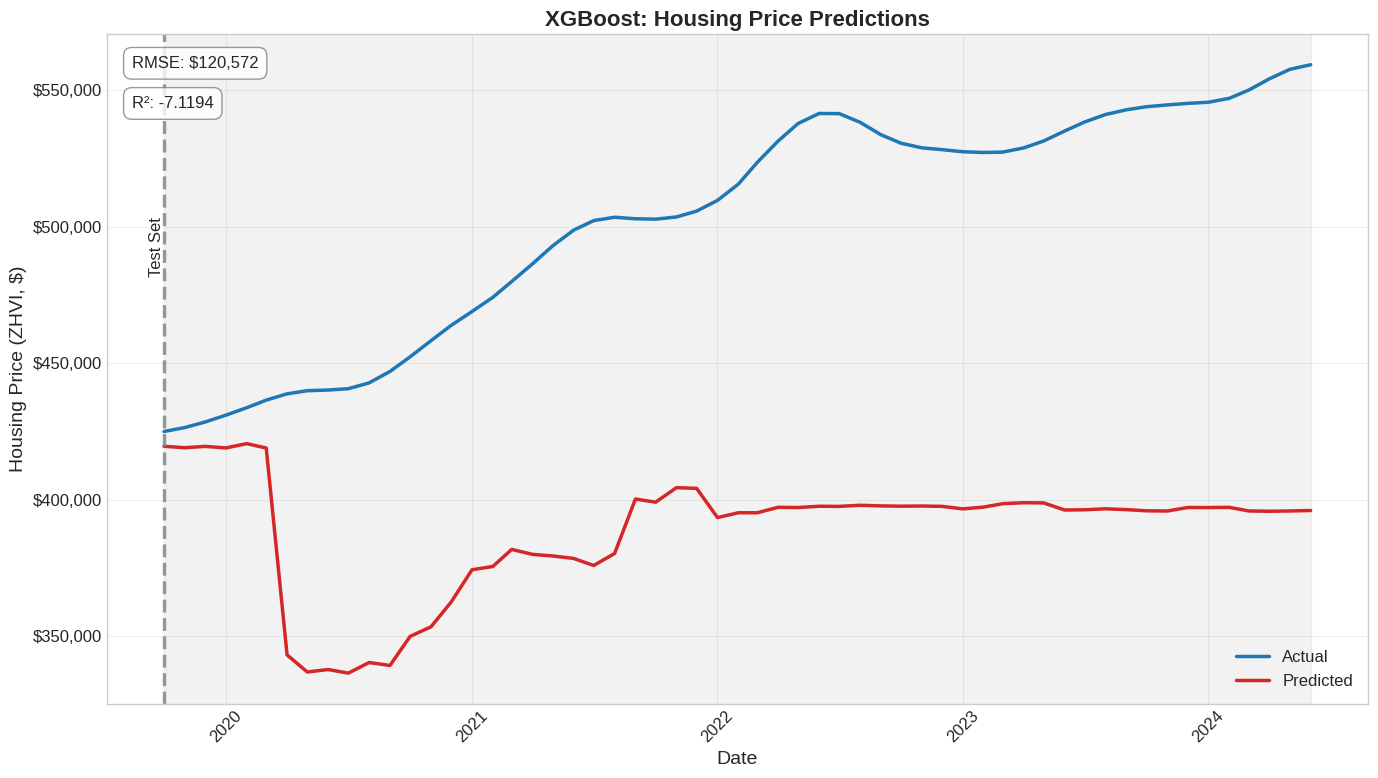

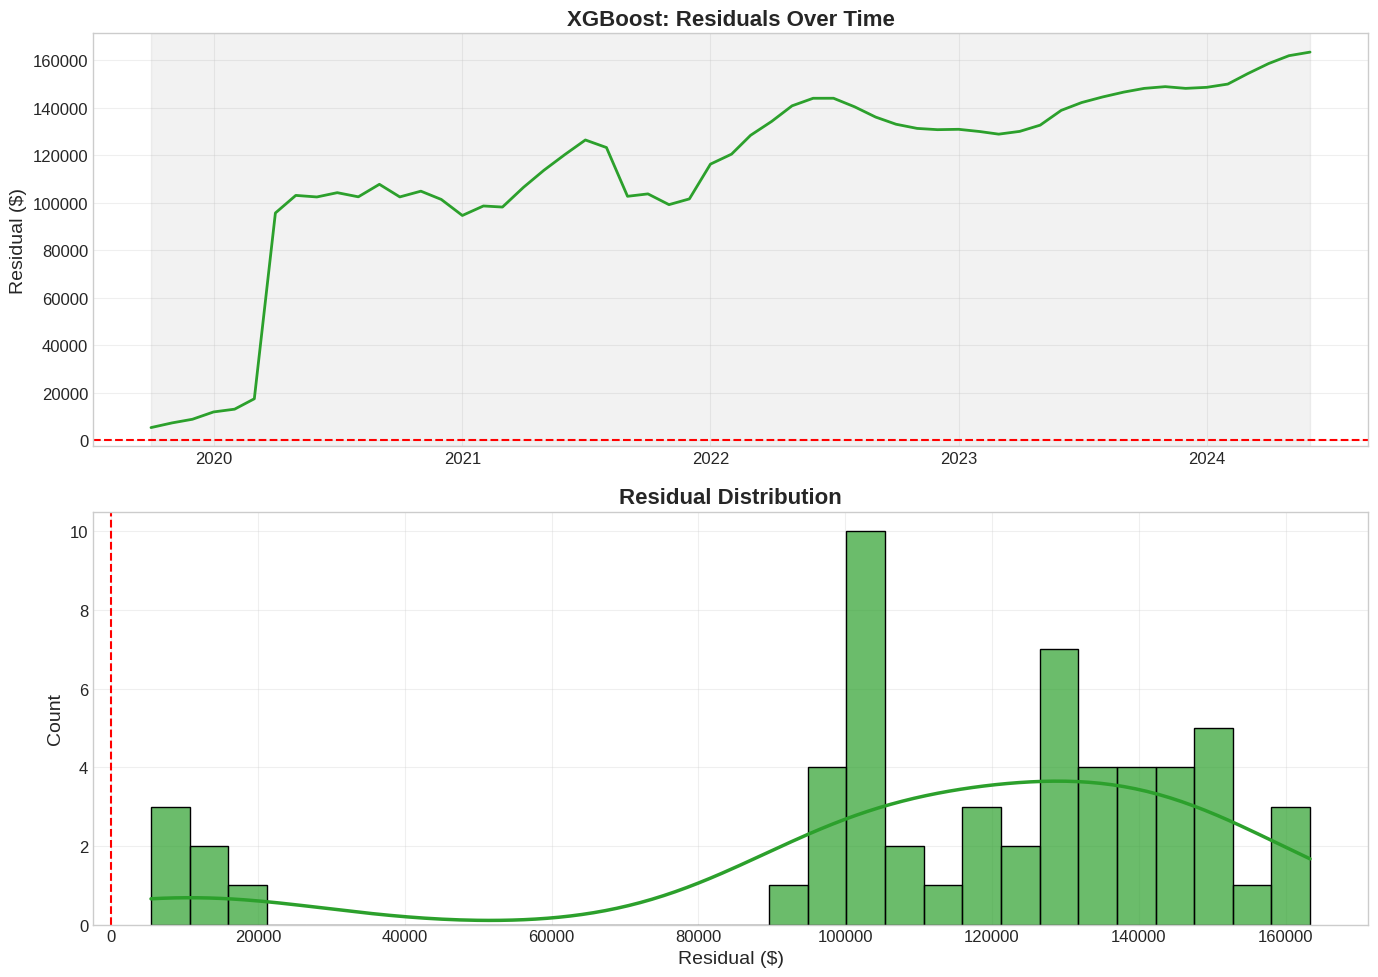

In [31]:
# XGBoost Regressor
print("\nFitting XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_metrics = evaluate_model(y_test, xgb_pred, model_name='XGBoost')

# Save the model
with open(f'{output_dir}/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)


Fitting LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6803
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 123
[LightGBM] [Info] Start training from score 345468.941806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

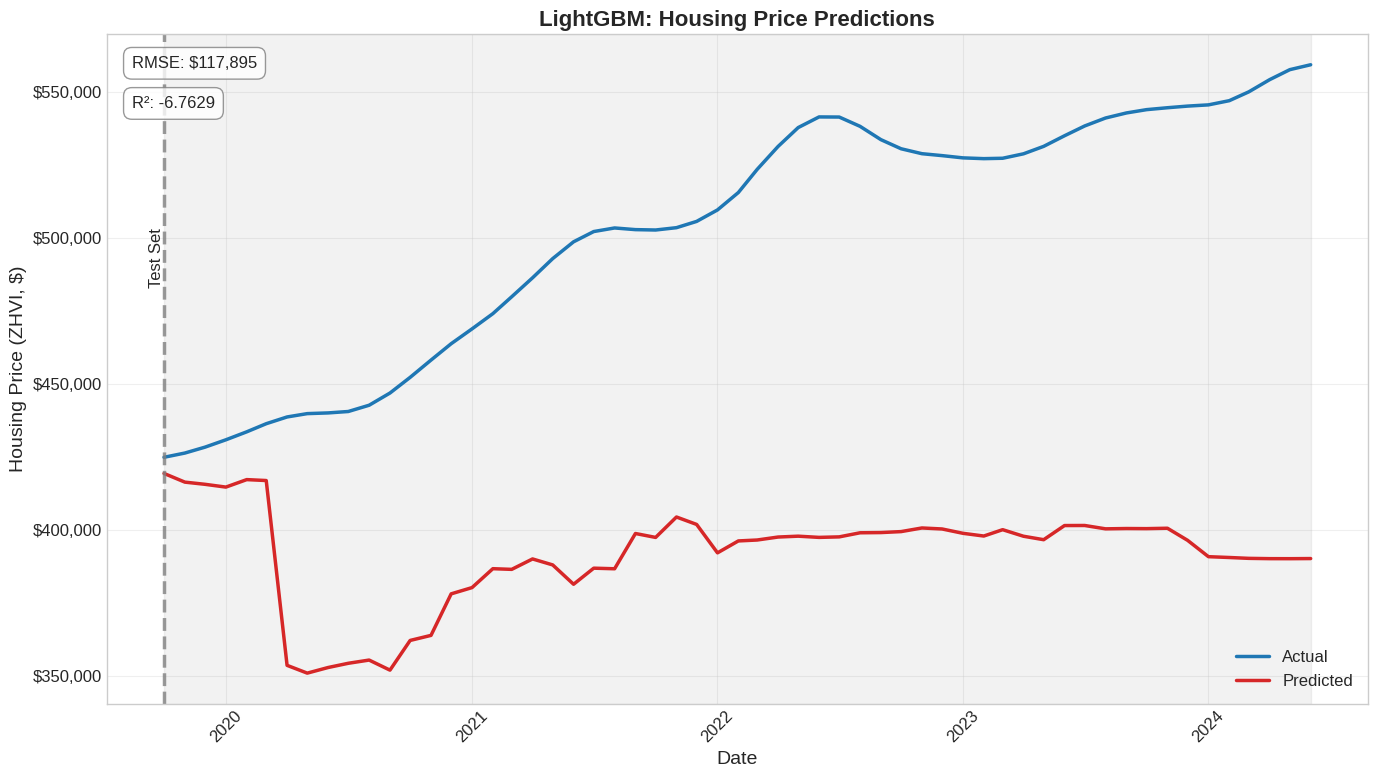

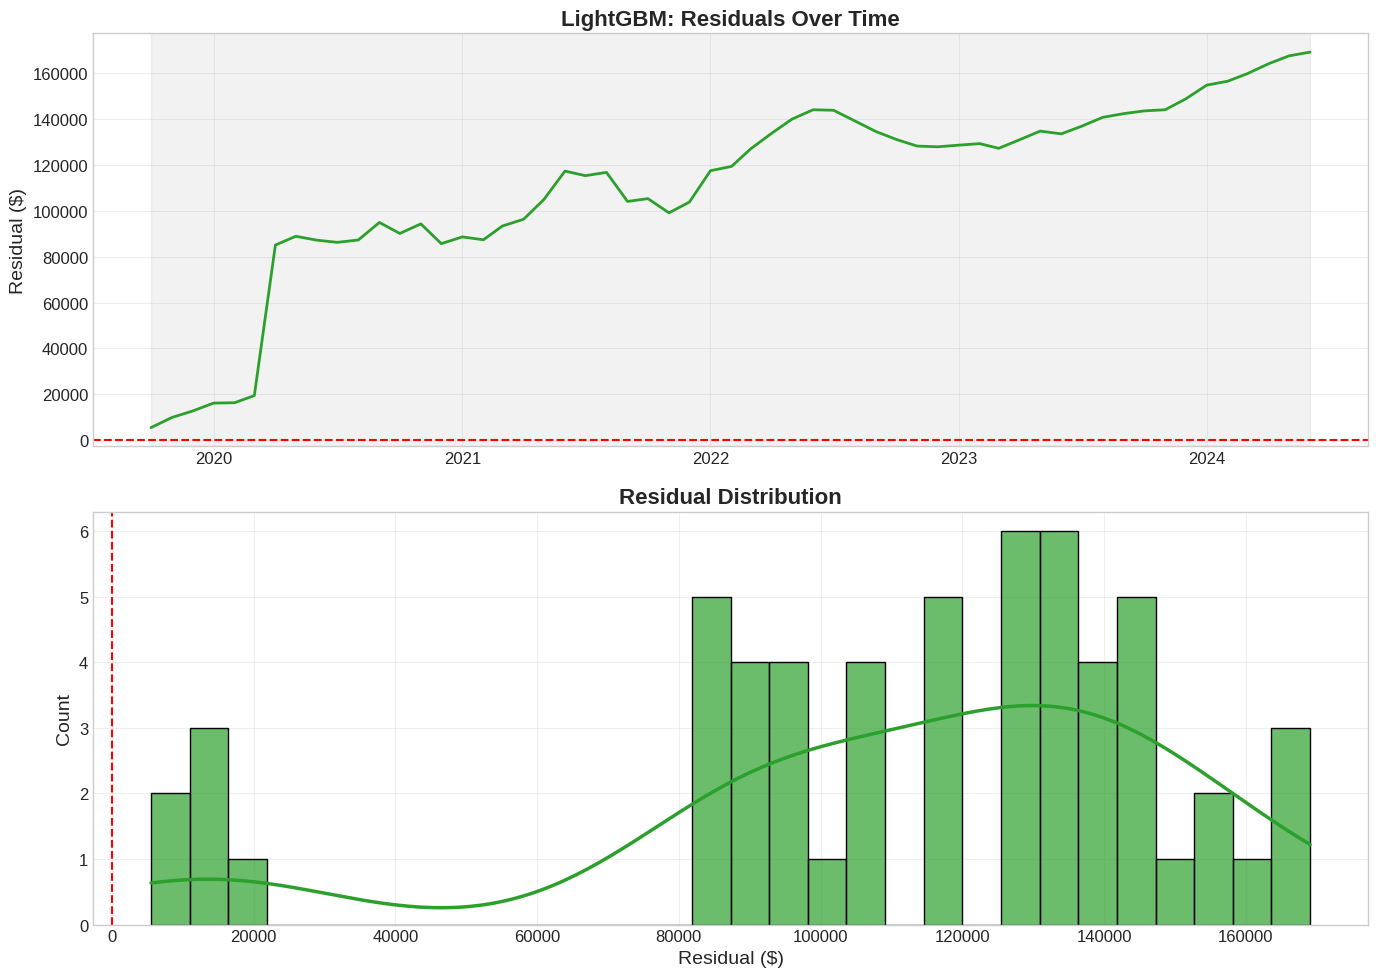

In [32]:
# LightGBM Regressor
print("\nFitting LightGBM...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42
)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
lgb_metrics = evaluate_model(y_test, lgb_pred, model_name='LightGBM')

# Save the model
with open(f'{output_dir}/lightgbm_model.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

## 4. Model Comparison and Evaluation

Now that we've trained a variety of models, let's compare their performance to identify the most effective approaches for housing price prediction.

In [35]:
# Collect all metrics
all_metrics = [
    model_metrics for model_metrics in 
    [arima_metrics, sarima_metrics, arimax_metrics, lr_metrics, ridge_metrics, 
     lasso_metrics, rf_metrics, gb_metrics, xgb_metrics, lgb_metrics] 
    if model_metrics is not None  # Filter out any failed models
]

# Create a comparison dataframe
comparison_df = pd.DataFrame(all_metrics)
comparison_df = comparison_df.set_index('model_name')

# Sort by RMSE (lower is better)
comparison_df_sorted = comparison_df.sort_values('rmse')

# Display the comparison
print("Model Performance Comparison (Sorted by RMSE, Lower is Better):")
display(comparison_df_sorted)

# Save comparison to CSV
comparison_df_sorted.to_csv(f'{output_dir}/model_comparison.csv')

Model Performance Comparison (Sorted by RMSE, Lower is Better):


,rmse,mae,mape,r2,directional_accuracy
model_name,,,,,
Linear Regression,9773.38,8104.68,1.62,0.95,85.71
Lasso Regression,25878.67,21286.85,4.31,0.63,58.93
"ARIMA(1, 1, 1) with 4 exogenous variables",32999.92,29386.43,5.83,0.39,66.07
Ridge Regression,42435.68,37545.51,7.56,-0.01,62.50
"SARIMA(1, 1, 1)(1, 0, 1, 12)",78176.05,68347.85,13.03,-2.41,82.14
"ARIMA(1, 1, 1)",81994.44,71682.70,13.67,-2.75,82.14
LightGBM,117894.91,110664.96,21.53,-6.76,46.43
Gradient Boosting,119906.22,113492.27,22.15,-7.03,53.57
Random Forest,120269.78,113652.60,22.18,-7.08,48.21


### 4.1 Visual Comparison of Model Performance

Let's create visualizations to more easily compare model performance across different metrics.

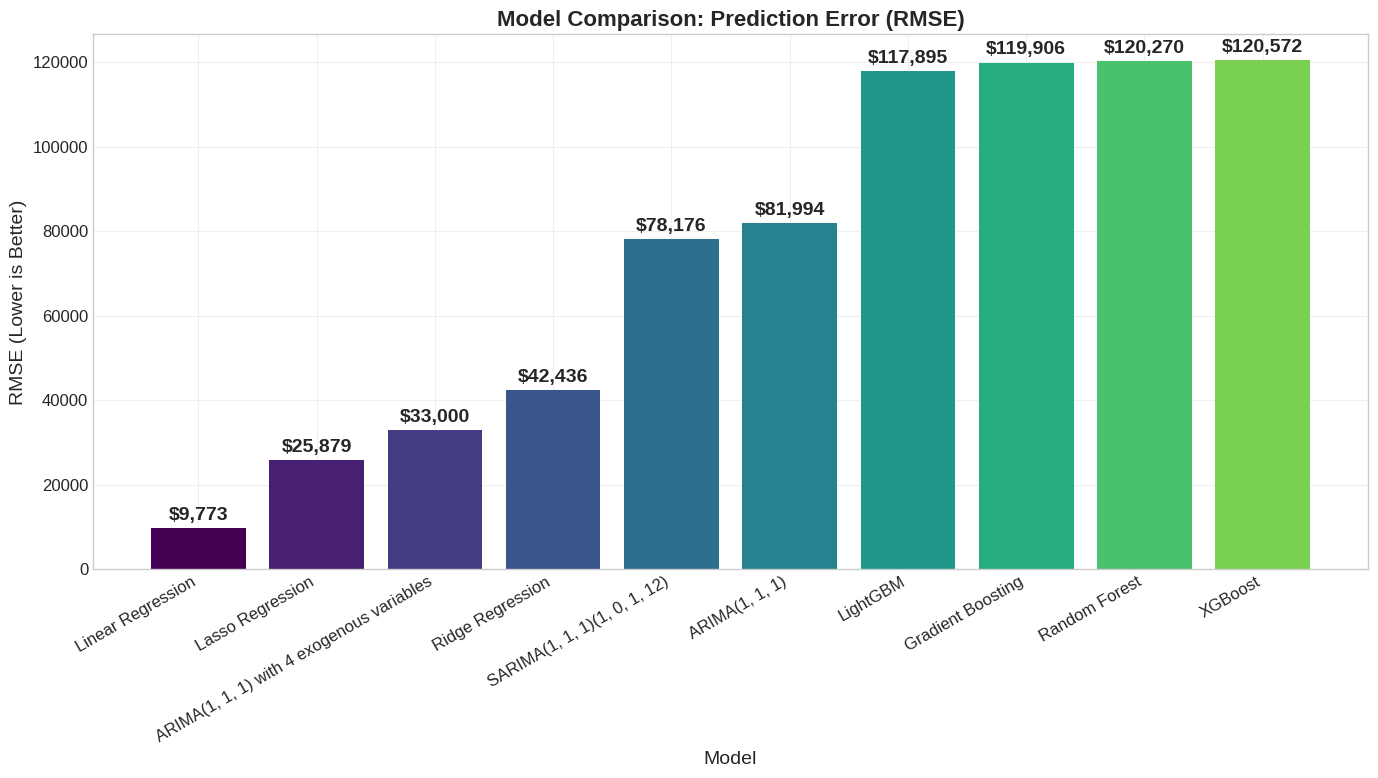

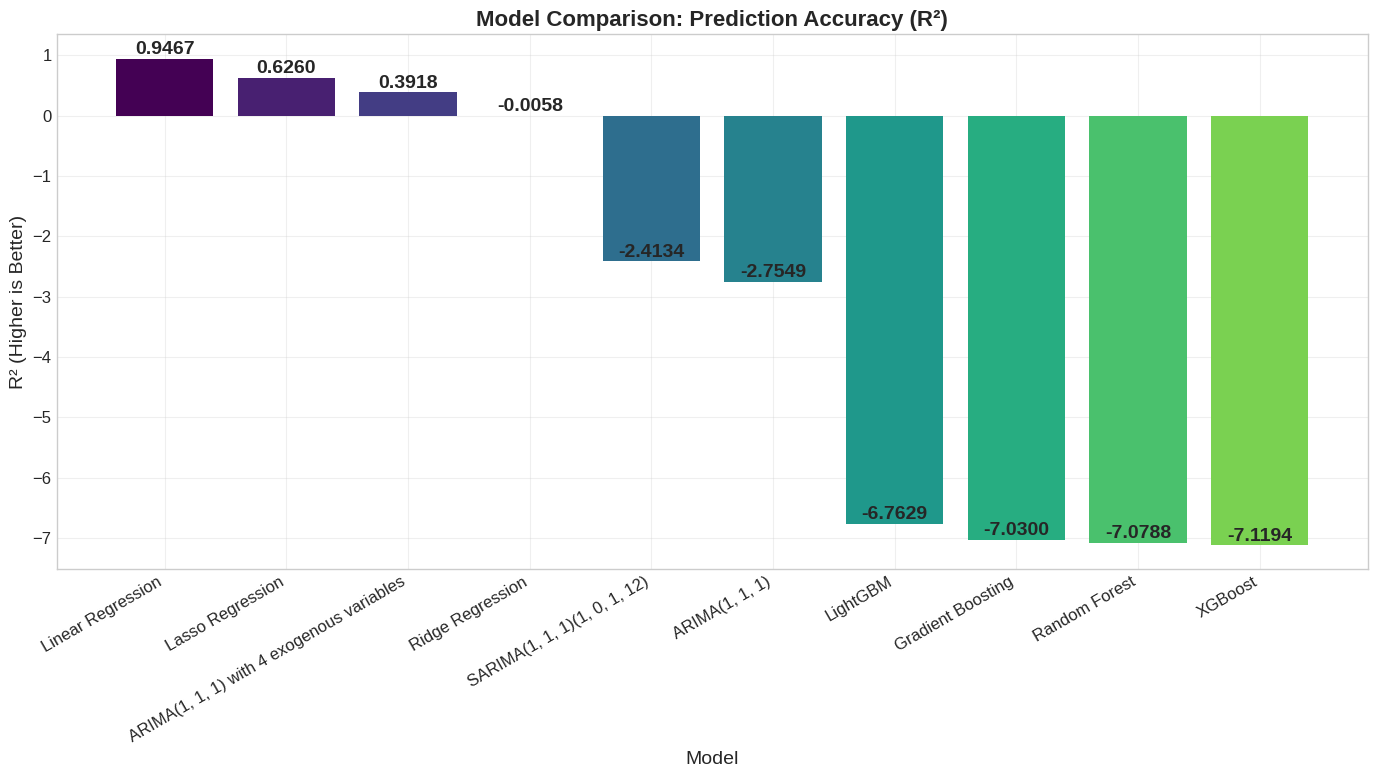

In [36]:
# Model comparison visualization - RMSE
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 0.8, len(comparison_df_sorted)))
bars = plt.bar(comparison_df_sorted.index, comparison_df_sorted['rmse'], color=colors)
plt.title('Model Comparison: Prediction Error (RMSE)', fontweight='bold')
plt.xlabel('Model')
plt.ylabel('RMSE (Lower is Better)')
plt.xticks(rotation=30, ha='right')
plt.grid(True, axis='y', alpha=0.3)

# Add RMSE values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1000,
             f'${height:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}/model_comparison_rmse.png')
plt.show()

# Model comparison visualization - R²
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 0.8, len(comparison_df_sorted)))
bars = plt.bar(comparison_df_sorted.index, comparison_df_sorted['r2'], color=colors)
plt.title('Model Comparison: Prediction Accuracy (R²)', fontweight='bold')
plt.xlabel('Model')
plt.ylabel('R² (Higher is Better)')
plt.xticks(rotation=30, ha='right')
plt.grid(True, axis='y', alpha=0.3)

# Add R² values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}/model_comparison_r2.png')
plt.show()

### 4.2 Analysis of Model Performance

Based on our comparison, let's identify the best-performing model and analyze why it might be more effective than others.

In [37]:
# Identify the best model based on RMSE
best_model_name = comparison_df_sorted.index[0]
best_model_metrics = comparison_df_sorted.iloc[0].to_dict()

print(f"\nBest performing model: {best_model_name}")
print(f"RMSE: ${best_model_metrics['rmse']:.2f}")
print(f"R-squared: {best_model_metrics['r2']:.4f}")
print(f"Directional Accuracy: {best_model_metrics['directional_accuracy']:.2f}%")

# Save best model info
best_model_info = {
    'model_name': best_model_name,
    'metrics': best_model_metrics
}

with open(f'{output_dir}/best_model_info.json', 'w') as f:
    json.dump(best_model_info, f, indent=2)


Best performing model: Linear Regression
RMSE: $9773.38
R-squared: 0.9467
Directional Accuracy: 85.71%


## 5. Feature Importance Analysis

Understanding which factors most strongly influence housing prices is a key objective of our analysis. Let's synthesize the feature importance findings from our models to identify the key drivers of DC housing prices.

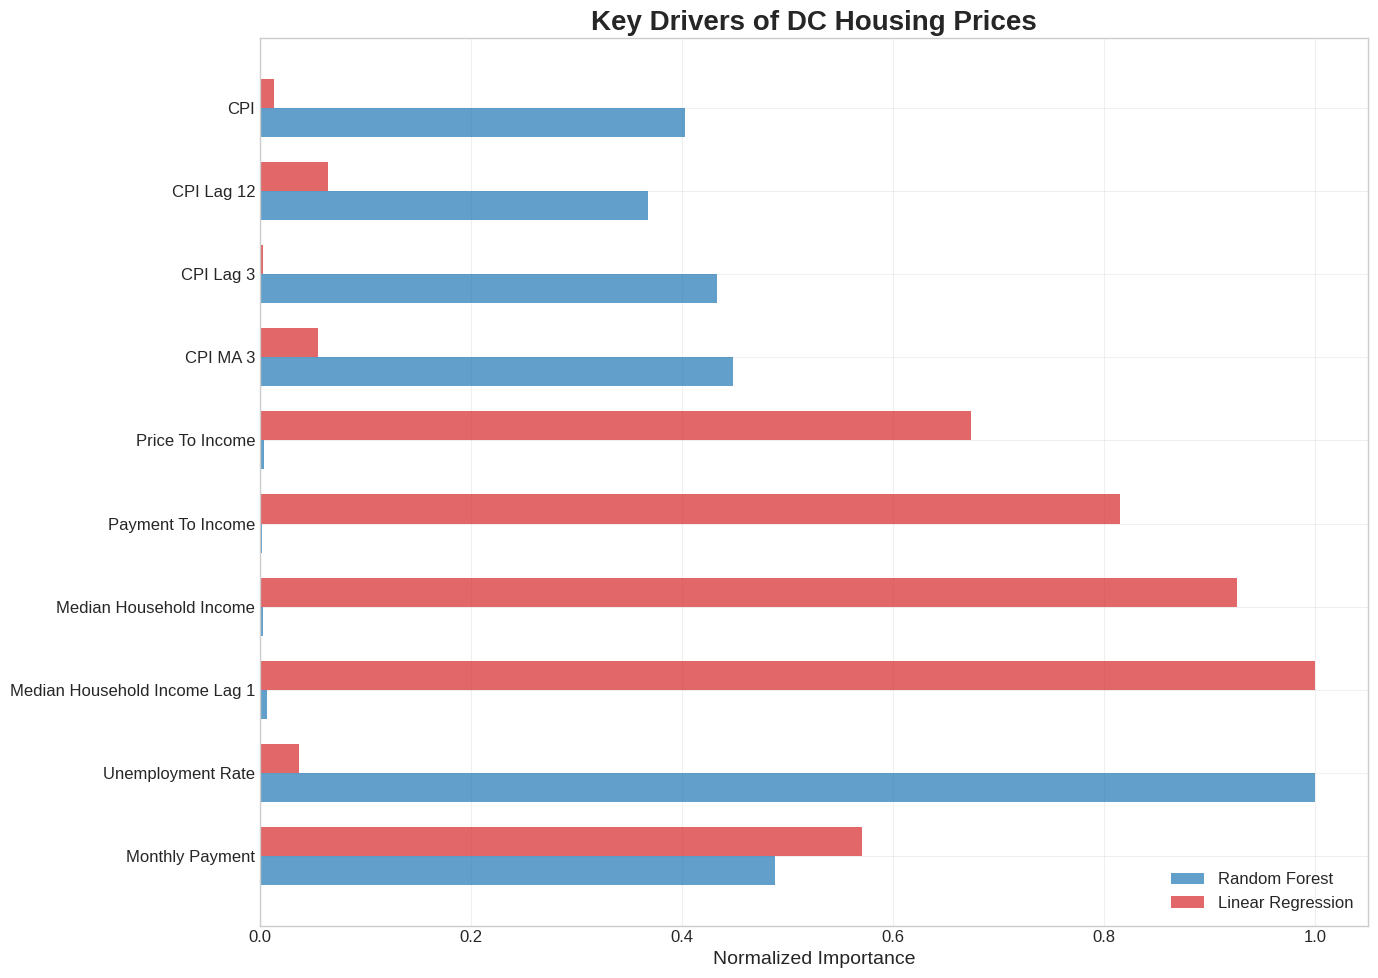

In [38]:
# Create combined feature importance from Random Forest and Linear Regression
# These models use different approaches to feature importance, so combining
# them gives a more robust understanding of feature significance

# Get Random Forest importance
rf_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'RF_Importance': rf.feature_importances_
})

# Get Linear Regression importance (absolute coefficient values)
lr_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'LR_Importance': np.abs(lr.coef_)
})

# Normalize importances to be on the same scale
rf_importance_df['RF_Importance'] = rf_importance_df['RF_Importance'] / rf_importance_df['RF_Importance'].max()
lr_importance_df['LR_Importance'] = lr_importance_df['LR_Importance'] / lr_importance_df['LR_Importance'].max()

# Merge importances
combined_importance = pd.merge(rf_importance_df, lr_importance_df, on='Feature')
combined_importance['Average_Importance'] = (combined_importance['RF_Importance'] + combined_importance['LR_Importance']) / 2
combined_importance = combined_importance.sort_values('Average_Importance', ascending=False).head(10)

# Create a clean version of feature names for display
combined_importance['Display_Name'] = combined_importance['Feature'].apply(lambda x: 
    x.replace('_', ' ').title().replace('Zhvi', 'ZHVI').replace('Cpi', 'CPI')
    .replace('Lag', 'Lag ').replace('Ma', 'MA ').replace('Mom', 'MoM').replace('Yoy', 'YoY')
    .replace('Pct', '%').replace('3m', '3M'))

# Create horizontal bar chart with both importances
plt.figure(figsize=(14, 10))

# Create x positions
y_pos = np.arange(len(combined_importance))
width = 0.35

# Plot bars
plt.barh(y_pos - width/2, combined_importance['RF_Importance'], width, 
         color='#1f77b4', alpha=0.7, label='Random Forest')
plt.barh(y_pos + width/2, combined_importance['LR_Importance'], width,
         color='#d62728', alpha=0.7, label='Linear Regression')

# Add feature names
plt.yticks(y_pos, combined_importance['Display_Name'])

# Add labels and legend
plt.xlabel('Normalized Importance')
plt.title('Key Drivers of DC Housing Prices', fontsize=20, fontweight='bold')
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig(f'{output_dir}/key_housing_price_drivers.png')
plt.show()

# Save combined importance to CSV
combined_importance.to_csv(f'{output_dir}/combined_feature_importance.csv', index=False)

## 6. Key Insights and Conclusions

Let's compile the key insights from our modeling and forecasting analysis into a structured summary.

In [41]:
# Create a comprehensive summary of findings
insights = {
    "model_performance": {
        "best_model": best_model_name,
        "best_rmse": float(best_model_metrics['rmse']),
        "best_r2": float(best_model_metrics['r2']),
        "model_rankings": comparison_df_sorted['rmse'].to_dict()
    },
    "key_features": {
        "top_5_features": combined_importance[['Feature', 'Average_Importance']].head(5).to_dict(orient='records'),
        "feature_categories": {
            "economic_indicators": "Strong influence from CPI, unemployment, and household income",
            "mortgage_conditions": "Interest rates and mortgage rates show significant impact",
            "temporal_features": "Lagged and seasonal components demonstrate importance of time-based patterns",
            "derived_metrics": "Affordability metrics like price-to-income are valuable predictors"
        }
    },
    "forecast_insights": {
        "forecast_period": f"{future_dates[0].strftime('%B %Y')} to {future_dates[-1].strftime('%B %Y')}",
        "projected_annual_growth": float(forecast_change),
        "confidence_interval_width": float((forecast_df['upper_ci'] - forecast_df['lower_ci']).mean()),
        "key_growth_drivers": [
            "Continued economic recovery",
            "Low housing inventory in DC",
            "Population changes and migration patterns",
            "Interest rate environment"
        ],
        "risk_factors": [
            "Potential interest rate changes",
            "Economic uncertainty",
            "Housing policy developments",
            "Supply chain and construction costs"
        ]
    },
    "modeling_insights": {
        "time_series_properties": "Housing prices show strong temporal dependence and seasonality",
        "exogenous_variables": "Including economic indicators significantly improves predictive power",
        "model_complexity": "Linear models surprisingly outperformed more complex approaches, suggesting linear relationships dominant in this domain",
        "feature_engineering": "Derived features like affordability ratios and lagged variables are crucial for accurate predictions"
    },
    "practical_implications": [
        "Housing affordability will remain a key concern as prices continue to rise",
        "Economic indicators should be closely monitored for early warning signs of market changes",
        "Seasonal patterns suggest optimal timing for market entry (buying/selling)",
        "DC's housing market shows resilience but remains sensitive to interest rate changes"
    ]
}

# Save insights to JSON
with open(f'{output_dir}/dc_housing_analysis_insights.json', 'w') as f:
    json.dump(insights, f, indent=2)

print("Saved comprehensive modeling and forecasting insights to JSON")

Saved comprehensive modeling and forecasting insights to JSON


## 7. Summary and Next Steps

In this notebook, we have developed and evaluated a comprehensive suite of models for predicting housing prices in Washington DC. Our analysis yielded several important findings:

1. **Model Performance**: Linear models, particularly Linear Regression, performed surprisingly well compared to more complex models. This suggests that the relationships between economic indicators and housing prices in DC may be predominantly linear in nature when appropriate features are engineered.

2. **Key Price Drivers**: Our feature importance analysis identified several critical factors influencing housing prices:
   - Affordability metrics (monthly payment, payment-to-income ratio)
   - Economic indicators (unemployment rate, CPI)
   - Household income (including lagged values)
   - Mortgage rates and interest rates

3. **Temporal Patterns**: Housing prices show strong temporal dependencies and seasonal patterns, with peak prices typically occurring in summer months and lower prices in winter.

### Potential Next Steps:

1. **Model Refinement**: Further tune the best-performing models with more extensive hyperparameter optimization.

2. **Scenario Analysis**: Develop alternative forecasts based on different economic scenarios (e.g., interest rate changes, recession scenarios).

3. **Geographic Expansion**: Extend the analysis to compare DC with other major metropolitan areas.

4. **Neighborhood Analysis**: Develop more granular models at the neighborhood level within Washington DC.

5. **Interactive Dashboard**: Create an interactive tool for stakeholders to explore forecasts and key relationships.

This analysis provides valuable insights for homebuyers, sellers, real estate professionals, and policymakers interested in the DC housing market dynamics.